In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%set_env XLA_PYTHON_CLIENT_MEM_FRACTION=.5

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.5


In [149]:
%load_ext autoreload 
%autoreload 2
import lenses

from flox.util import key_chain

from rigid_flows.flow import build_flow
from rigid_flows.specs import FlowSpecification, CouplingSpecification, ExperimentSpecification
# from rigid_flows.density import PositionPrior, RotationPrior

chain = key_chain(42)


specs = ExperimentSpecification.load_from_file("dummy.yaml")
# specs = lenses.bind(specs).model.flow.couplings.set(())

from rigid_flows.data import Data


from rigid_flows.density import OpenMMDensity

base = OpenMMDensity.from_specs((16, 3), specs.model.base)
target = OpenMMDensity.from_specs((16, 3), specs.model.target)


data = Data.from_specs(specs.model.target, target.box)

[autoreload of rigid_flows.flow failed: Traceback (most recent call last):
  File "/home/jonas/miniconda3/envs/rigid-flows/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/jonas/miniconda3/envs/rigid-flows/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jonas/miniconda3/envs/rigid-flows/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/jonas/miniconda3/envs/rigid-flows/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/home/jonas/miniconda3/envs/rigid-flows/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot a

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
from rigid_flows.data import PreprocessedData
from rigid_flows.system import SimulationBox
from jax import numpy as jnp

data_ = PreprocessedData.from_data(
    data,
    SimulationBox(jnp.diag(target.omm_model.model.box)),
)

In [151]:
data_.estimate_com_stats()

(Array([0.4499547 , 0.42170066, 0.31817386], dtype=float32),
 Array([0.00383701, 0.00236153, 0.00489729], dtype=float32))

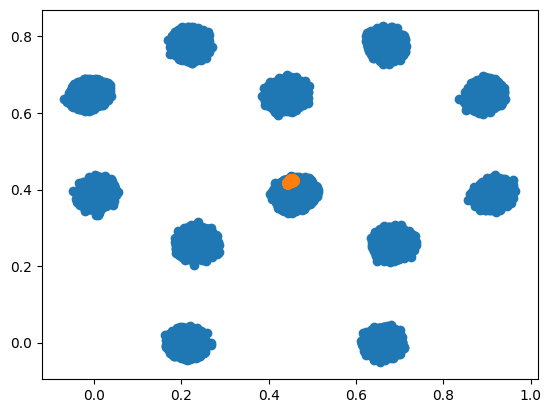

In [152]:
from matplotlib import pyplot as plt


plt.scatter(*data_.pos[:, :, 0, (0, 1)].T)
plt.scatter(*data_.pos.mean(axis=(1, 2))[:, (0, 1)].T)

In [153]:
flow = build_flow(next(chain), (16, 3), specs.model.flow, base, target)

In [154]:
import jax

from rigid_flows.flow import toggle_layer_stack, initialize_actnorm
import equinox as eqx 

@eqx.filter_jit
def init_actnorm(flow, key):
    actnorm_batch = jax.vmap(target.sample)(
        jax.random.split(key, specs.act_norm_init_samples)
    ).obj
    flow = toggle_layer_stack(flow, False)
    flow, _ = initialize_actnorm(flow, actnorm_batch)
    flow = toggle_layer_stack(flow, True)
    return flow

flow = init_actnorm(flow, next(chain))


In [155]:
from rigid_flows.flow import EuclideanToRigidTransform

In [156]:
# from matplotlib import pyplot as plt

# asdf = boxify(
#     data.pos, target.box
# )

# idx = jnp.arange(len(asdf))
# idx = jax.random.shuffle(next(chain), idx)

# view = (1,2)
# plt.scatter(*asdf[idx[:100]][..., 0, view].T)
# plt.scatter(*asdf[idx[:100]][..., 1, view].T)
# plt.scatter(*asdf[idx[:100]][..., 2, view].T)



In [157]:
    # d_OH1: Scalar = jnp.array(0.09572)
    # d_OH2: Scalar = jnp.array(0.09572)
    # a_HOH: Scalar = jnp.array(1.82421813418)
    # d_OM: Scalar = jnp.array(0.0125)
    # a_OM: Scalar = jnp.array(1.82421813418 / 2)

In [158]:
from rigid_flows.flow import RigidTransform, to_rigid, from_rigid

In [159]:
import jax
from functools import partial
from flox.flow import bind, Inverted

samples = jax.vmap(base.sample)(jax.random.split(next(chain), 1000))
out = jax.vmap(
    lambda x: bind(x, flow)
)(samples)





# keys = jax.random.split(next(chain), 100)





In [160]:
def loss(flow):
    out = jax.vmap(
        lambda x: bind(x, flow)
    )(samples)
    # return jnp.square(out.obj.pos).sum()
    # out = samples 
    return jnp.mean(jax.vmap(target.potential)(out.obj) - out.ldj)

In [161]:
grad = eqx.filter_grad(loss)(flow)

In [163]:
flow = jax.tree_map(
    lambda node, grad: node - 1e-3 * grad if eqx.is_array(node) else node, flow, grad
)

In [165]:
grad = eqx.filter_grad(loss)(flow)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [164]:
from dataclasses import is_dataclass


def traverse(d, callback, prefix=""):
    if is_dataclass(d):
        for name, field in d.__dataclass_fields__.items():
            traverse(getattr(d, name), callback, prefix + "." + name)
    elif isinstance(d, list) | isinstance(d, tuple):
        for i, item in enumerate(d):
            traverse(item, callback, prefix + f"[{i}]:{type(item).__name__}")
    else:
        callback(prefix, d)
        
traverse(grad, lambda p, x: print(p, jnp.sum(jnp.square(x))) if eqx.is_array(x) else None)

.transforms[1]:Pipe.transforms[0]:Pipe.transforms[0]:Pipe.transforms[0]:AuxUpdate.net.blocks[0]:tuple[0]:AuxiliaryConditionerBlock.nodes_kq.weight 1.6321985e-11
.transforms[1]:Pipe.transforms[0]:Pipe.transforms[0]:Pipe.transforms[0]:AuxUpdate.net.blocks[0]:tuple[0]:AuxiliaryConditionerBlock.nodes_kq.bias 5.9328003e-12
.transforms[1]:Pipe.transforms[0]:Pipe.transforms[0]:Pipe.transforms[0]:AuxUpdate.net.blocks[0]:tuple[0]:AuxiliaryConditionerBlock.pos_kq.weight 4.4344786e-10
.transforms[1]:Pipe.transforms[0]:Pipe.transforms[0]:Pipe.transforms[0]:AuxUpdate.net.blocks[0]:tuple[0]:AuxiliaryConditionerBlock.pos_kq.bias 8.528243e-11
.transforms[1]:Pipe.transforms[0]:Pipe.transforms[0]:Pipe.transforms[0]:AuxUpdate.net.blocks[0]:tuple[0]:AuxiliaryConditionerBlock.rot_kq.weight 3.5532036e-11
.transforms[1]:Pipe.transforms[0]:Pipe.transforms[0]:Pipe.transforms[0]:AuxUpdate.net.blocks[0]:tuple[0]:AuxiliaryConditionerBlock.values.weight 2.0913726e-09
.transforms[1]:Pipe.transforms[0]:Pipe.transfor

In [41]:
target.box.size

Array([0.89846, 0.77808, 0.73358], dtype=float32)

In [42]:
samples.obj.box.size[0]

Array([0.89846, 0.77808, 0.73358], dtype=float32)

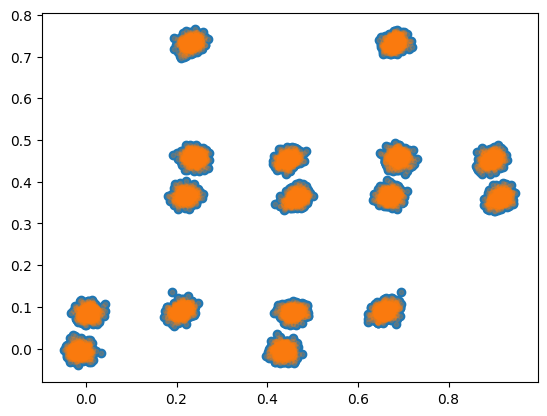

In [43]:
from matplotlib import pyplot as plt


plt.scatter(*(out.obj.pos[:, :, 0])[..., (0,2)].T)

plt.scatter(*(samples.obj.pos[:, :, 0])[..., (0, 2)].T, marker=".", alpha=0.2)
# plt.scatter(*data_.pos.mean(axis=(1, 2))[:, (0, 1)].T)

In [76]:
from rigid_flows.reporting import plot_oxygen_positions

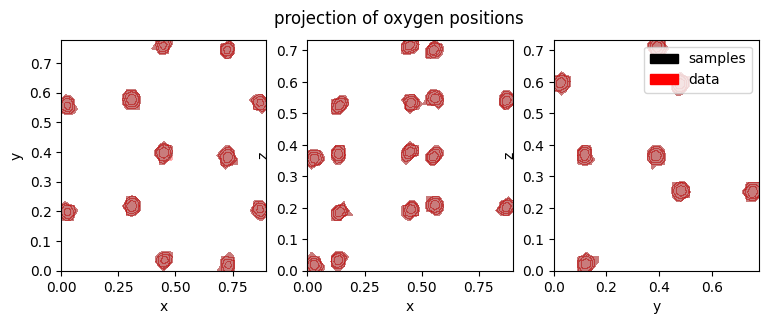

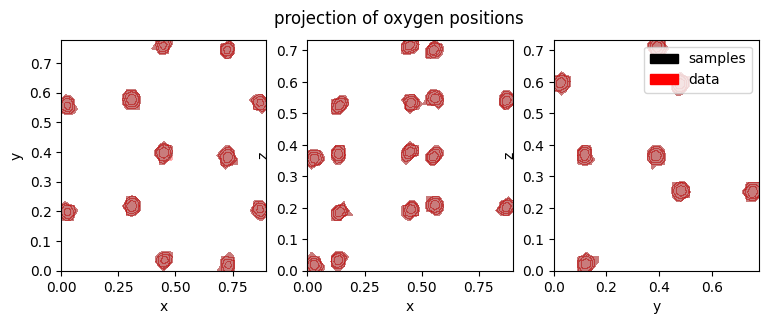

In [77]:
plot_oxygen_positions(
    out.obj.pos[:, :, 0], samples.obj.pos[:, :, 0], target.box
)

In [120]:
from flox._src.flow import rigid

In [121]:
# x = jax.random.normal(next(chain), shape=(3, 3))

# ic = q, p, d1, d2, a = rigid.from_euclidean(x)

# def pot(q, p, d1, d2, a):
#     return (
#         jnp.square(q - jnp.eye(4)[0]).sum() +
#         jnp.square(p).sum() +
#         jnp.square(d1 - 0.2).sum() +
#         jnp.square(d2 - 0.2).sum() +
#         jnp.square(a - 0.5).sum()
#     )

# def pot2(x):
#     return jnp.square(jnp.eye(3) - x).sum()

In [122]:
# step = jax.jit(jax.value_and_grad(lambda x: pot2(rigid.to_euclidean(*rigid.from_euclidean(x)))))
# step2 = jax.jit(jax.value_and_grad(lambda ic: pot2(rigid.to_euclidean(*ic))))

In [123]:
# for i in range(100):
#     v, g = step(x)
#     x = x - 0.01 * g
#     print(v)

In [129]:
import jax
import jax.numpy as jnp
from flox import geom
from flox.util import key_chain
import equinox as eqx

chain = key_chain(53)



class RotationConditionerBlock(eqx.Module):

    nodes_kq: eqx.nn.Linear
    pos_kq: eqx.nn.Linear
    aux_kq: eqx.nn.Linear
    values: eqx.nn.Linear
    num_heads: int

    def __init__(self, node_dim: int, num_aux: int, num_heads: int, num_channels: int, *, key) -> None:
        chain = key_chain(key)
        self.num_heads = num_heads
        self.nodes_kq = eqx.nn.Linear(
            node_dim,
            num_heads * num_channels * 2,
            key=next(chain)
        )
        self.pos_kq = eqx.nn.Linear(
            2 * 3,
            num_heads * num_channels * 2,
            key=next(chain)
        )
        self.aux_kq = eqx.nn.Linear(
            num_aux,
            num_heads * num_channels * 2,
            use_bias=False,
            key=next(chain)
        )
        self.values = eqx.nn.Linear(
            node_dim,
            node_dim * num_heads * 3,
            key=next(chain)
        )

    def __call__(self, nodes, pos, aux):
        pos = jnp.concatenate([jnp.cos(2 * jnp.pi * pos), jnp.sin(2 * jnp.pi * pos)], axis=-1)

        seq_len = nodes.shape[0]
        
        val = jax.vmap(self.values)(nodes).reshape(seq_len, 3 * self.num_heads, -1)

        nodes_k, nodes_q = jnp.split(jax.vmap(self.nodes_kq)(nodes).reshape(seq_len, self.num_heads, -1), 2, -1)
        pos_k, pos_q = jnp.split(jax.vmap(self.pos_kq)(pos).reshape(seq_len, self.num_heads, -1), 2, -1)

        aux_k, aux_q = jnp.split(jax.vmap(self.aux_kq)(aux).reshape(seq_len, self.num_heads, -1), 2, -1)

        k = jnp.concatenate([nodes_k, pos_k, aux_k], axis=-2)
        q = jnp.concatenate([nodes_q, pos_q, aux_q], axis=-2)

        logits = jnp.einsum('ihc, jhc -> ijh', k, q)

        att = jax.nn.softmax(logits, axis=-2)
        out = jnp.einsum('ijh, jhd -> id', att, val)

        return out


class RotConditioner(eqx.Module):

    blocks: list[tuple[RotationConditionerBlock, eqx.nn.LayerNorm]]
    decoder: eqx.nn.Linear

    def __init__(self, inp, out, num_aux, num_heads, num_channels, num_blocks, *, key) -> None:
        chain = key_chain(key)
        self.blocks = [
            (
                RotationConditionerBlock(inp, num_aux, num_heads, num_channels, key=next(chain)),
                eqx.nn.LayerNorm((inp,), elementwise_affine=True)
            )
            for _ in range(num_blocks)
        ]
        self.decoder = eqx.nn.Linear(
            inp, out, use_bias=True, key=next(chain)
        )

    def __call__(self, pos, rot):
        seq_len = pos.shape[0]
        nodes = jnp.eye(seq_len)
        for block, norm in self.blocks:
            nodes = nodes + jax.vmap(norm)(block(nodes, pos, rot))
        return jax.vmap(self.decoder)(nodes)



cond = RotConditioner(
    inp=16,
    out=5,
    num_aux=3,
    num_heads=4, 
    num_channels=8,
    num_blocks=2,
    key=next(chain)
)

node = jax.random.normal(next(chain), (16, 16))
pos = jax.random.normal(next(chain), (16, 3))
aux = jax.vmap(geom.unit)(jax.random.normal(next(chain), (16, 3)))

sign = jnp.sign(jax.random.normal(next(chain), (16, 1)))

cond(pos, aux)

Array([[ 0.44025144, -0.1725155 , -0.81806195,  0.12070216, -1.1831763 ],
       [ 0.2733817 , -0.16452745, -0.4415808 ,  0.17914903, -1.43257   ],
       [ 0.04819296, -0.5254259 , -0.6393883 ,  0.10785531, -1.4556041 ],
       [-0.03089684, -0.35126245, -0.8733287 ,  0.4818508 , -1.3517187 ],
       [ 0.41557765, -0.6441891 , -0.82299066,  0.5670546 , -1.4802809 ],
       [ 0.2760811 , -0.2617519 , -0.58296794,  0.04890297, -1.0306809 ],
       [ 0.006561  , -0.27030835, -0.5108931 ,  0.35066792, -1.4070058 ],
       [ 0.15519848, -0.5518894 , -0.77131796,  0.4956745 , -1.0926243 ],
       [ 0.16074441, -0.3358147 , -0.35695758,  0.21604225, -1.355859  ],
       [ 0.35347834, -0.53475815, -0.7801682 ,  0.23752719, -1.0732574 ],
       [ 0.32353228, -0.19125973, -0.5082359 ,  0.42170805, -1.0272945 ],
       [ 0.21815327, -0.38540232, -0.43540686,  0.18227822, -1.4008367 ],
       [ 0.08238696, -0.5834561 , -1.0004699 ,  0.37950233, -1.2667468 ],
       [ 0.22065169, -0.2915951 , -0.3

In [118]:
import jax
import jax.numpy as jnp
from flox import geom
from flox.util import key_chain
import equinox as eqx

chain = key_chain(53)



class AuxiliaryConditionerBlock(eqx.Module):

    nodes_kq: eqx.nn.Linear
    pos_kq: eqx.nn.Linear
    rot_kq: eqx.nn.Linear
    values: eqx.nn.Linear
    num_heads: int

    def __init__(self, node_dim: int, num_heads: int, num_channels: int, *, key) -> None:
        chain = key_chain(key)
        self.num_heads = num_heads
        self.nodes_kq = eqx.nn.Linear(
            node_dim,
            num_heads * num_channels * 2,
            key=next(chain)
        )
        self.pos_kq = eqx.nn.Linear(
            2 * 3,
            num_heads * num_channels * 2,
            key=next(chain)
        )
        self.rot_kq = eqx.nn.Linear(
            4,
            num_heads * num_channels * 2,
            use_bias=False,
            key=next(chain)
        )
        self.values = eqx.nn.Linear(
            node_dim,
            node_dim * num_heads * 3,
            key=next(chain)
        )

    def __call__(self, nodes, pos, rot):
        pos = jnp.concatenate([jnp.cos(2 * jnp.pi * pos), jnp.sin(2 * jnp.pi * pos)], axis=-1)

        seq_len = nodes.shape[0]
        
        val = jax.vmap(self.values)(nodes).reshape(seq_len, 3 * self.num_heads, -1)

        nodes_k, nodes_q = jnp.split(jax.vmap(self.nodes_kq)(nodes).reshape(seq_len, self.num_heads, -1), 2, -1)
        pos_k, pos_q = jnp.split(jax.vmap(self.pos_kq)(pos).reshape(seq_len, self.num_heads, -1), 2, -1)
        
        rot_k, rot_q = jnp.split(jax.vmap(self.rot_kq)(rot).reshape(seq_len, self.num_heads, -1), 2, -1)

        k = jnp.concatenate([nodes_k, pos_k, rot_k], axis=-2)
        q = jnp.concatenate([nodes_q, pos_q, rot_q], axis=-2)

        logits = jnp.einsum('ihc, jhc -> ijh', k, q)
        logits = logits.at[..., -self.num_heads:].set(
            jnp.square(logits[..., -self.num_heads:])
        )
        att = jax.nn.softmax(logits, axis=-2)
        out = jnp.einsum('ijh, jhd -> id', att, val)

        return out


class AuxConditioner(eqx.Module):

    blocks: list[tuple[AuxiliaryConditionerBlock, eqx.nn.LayerNorm]]
    decoder: eqx.nn.Linear

    def __init__(self, inp, out, num_heads, num_channels, num_blocks, *, key) -> None:
        chain = key_chain(key)
        self.blocks = [
            (
                AuxiliaryConditionerBlock(inp, num_heads, num_channels, key=next(chain)),
                eqx.nn.LayerNorm((inp,), elementwise_affine=True)
            )
            for _ in range(num_blocks)
        ]
        self.decoder = eqx.nn.Linear(
            inp, out, use_bias=True, key=next(chain)
        )

    def __call__(self, pos, rot):
        seq_len = pos.shape[0]
        nodes = jnp.eye(seq_len)
        for block, norm in self.blocks:
            nodes = nodes + jax.vmap(norm)(block(nodes, pos, rot))
        return jax.vmap(self.decoder)(nodes)



cond = AuxConditioner(
    inp=16,
    out=5,
    num_heads=4, 
    num_channels=8,
    num_blocks=2,
    key=next(chain)
)

node = jax.random.normal(next(chain), (16, 16))
pos = jax.random.normal(next(chain), (16, 3))
rot = jax.vmap(geom.unit)(jax.random.normal(next(chain), (16, 4)))

sign = jnp.sign(jax.random.normal(next(chain), (16, 1)))
rot_ = sign * rot

cond(pos, rot)

Array([[ 3.6763591e-01, -2.0160495e-01, -8.7315345e-01,  1.9431815e-01,
        -1.2714398e+00],
       [ 2.7027631e-01, -1.7321320e-01, -4.2079619e-01,  2.2130537e-01,
        -1.4756603e+00],
       [ 3.7827313e-02, -5.2449989e-01, -6.8626845e-01,  9.9978507e-02,
        -1.4051824e+00],
       [ 7.8070611e-03, -2.8933641e-01, -8.2201821e-01,  4.3039578e-01,
        -1.2970090e+00],
       [ 4.4088954e-01, -6.0807449e-01, -8.1904298e-01,  5.3564024e-01,
        -1.4185362e+00],
       [ 2.7838263e-01, -2.3769325e-01, -6.0551971e-01,  6.8642199e-04,
        -9.6656865e-01],
       [ 4.8358247e-02, -2.1858074e-01, -4.9004334e-01,  3.2114258e-01,
        -1.3517041e+00],
       [ 1.4448224e-01, -5.3802621e-01, -7.0735461e-01,  5.0659966e-01,
        -1.1308177e+00],
       [ 9.8747328e-02, -3.7036717e-01, -3.5524595e-01,  2.9333243e-01,
        -1.4857423e+00],
       [ 3.8774770e-01, -5.1695824e-01, -7.3492914e-01,  2.3973492e-01,
        -1.0647759e+00],
       [ 2.7027315e-01, -2.013

In [123]:
import jax
import jax.numpy as jnp
from flox import geom
from flox.util import key_chain
import equinox as eqx

chain = key_chain(53)



class PositionConditionerBlock(eqx.Module):

    nodes_kq: eqx.nn.Linear
    aux_kq: eqx.nn.Linear
    rot_kq: eqx.nn.Linear
    values: eqx.nn.Linear
    num_heads: int

    def __init__(self, node_dim: int, num_aux: int, num_heads: int, num_channels: int, *, key) -> None:
        chain = key_chain(key)
        self.num_heads = num_heads
        self.nodes_kq = eqx.nn.Linear(
            node_dim,
            num_heads * num_channels * 2,
            key=next(chain)
        )
        self.aux_kq = eqx.nn.Linear(
            num_aux,
            num_heads * num_channels * 2,
            key=next(chain)
        )
        self.rot_kq = eqx.nn.Linear(
            4,
            num_heads * num_channels * 2,
            use_bias=False,
            key=next(chain)
        )
        self.values = eqx.nn.Linear(
            node_dim,
            node_dim * num_heads * 3,
            key=next(chain)
        )

    def __call__(self, nodes, aux, rot):
        seq_len = nodes.shape[0]
        
        val = jax.vmap(self.values)(nodes).reshape(seq_len, 3 * self.num_heads, -1)

        nodes_k, nodes_q = jnp.split(jax.vmap(self.nodes_kq)(nodes).reshape(seq_len, self.num_heads, -1), 2, -1)
        aux_k, aux_q = jnp.split(jax.vmap(self.aux_kq)(aux).reshape(seq_len, self.num_heads, -1), 2, -1)
        rot_k, rot_q = jnp.split(jax.vmap(self.rot_kq)(rot).reshape(seq_len, self.num_heads, -1), 2, -1)

        k = jnp.concatenate([nodes_k, aux_k, rot_k], axis=-2)
        q = jnp.concatenate([nodes_q, aux_q, rot_q], axis=-2)

        logits = jnp.einsum('ihc, jhc -> ijh', k, q)
        logits = logits.at[..., -self.num_heads:].set(
            jnp.square(logits[..., -self.num_heads:])
        )
        att = jax.nn.softmax(logits, axis=-2)
        out = jnp.einsum('ijh, jhd -> id', att, val)

        return out


class PosConditioner(eqx.Module):

    blocks: list[tuple[PositionConditionerBlock, eqx.nn.LayerNorm]]
    decoder: eqx.nn.Linear

    def __init__(self, inp, out, num_aux, num_heads, num_channels, num_blocks, *, key) -> None:
        chain = key_chain(key)
        self.blocks = [
            (
                PositionConditionerBlock(inp, num_aux, num_heads, num_channels, key=next(chain)),
                eqx.nn.LayerNorm((inp,), elementwise_affine=True)
            )
            for _ in range(num_blocks)
        ]
        self.decoder = eqx.nn.Linear(
            inp, out, use_bias=True, key=next(chain)
        )

    def __call__(self, aux, rot):
        seq_len = aux.shape[0]
        nodes = jnp.eye(seq_len)
        for block, norm in self.blocks:
            nodes = nodes + jax.vmap(norm)(block(nodes, aux, rot))
        return jax.vmap(self.decoder)(nodes)



cond = PosConditioner(
    inp=16,
    out=5,
    num_aux=3,
    num_heads=4, 
    num_channels=8,
    num_blocks=2,
    key=next(chain)
)

node = jax.random.normal(next(chain), (16, 16))
aux = jax.random.normal(next(chain), (16, 3))
rot = jax.vmap(geom.unit)(jax.random.normal(next(chain), (16, 4)))

sign = jnp.sign(jax.random.normal(next(chain), (16, 1)))
rot_ = sign * rot


Array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [121]:
# def loss(samples):
#     return jnp.sum(jnp.square(samples.obj.pos))

val, grad = jax.vmap(
    lambda samples: jax.value_and_grad(loss)(samples)
)(samples)
samples = lenses.bind(samples).set(jax.tree_map(lambda x, g: x - 1e-6 * g, samples, grad))
print(val)

NameError: name 'samples' is not defined

In [81]:
import jax.numpy as jnp

ugh = samples.obj.pos
com = jax.vmap(lambda key: target.com_model.sample(seed=key))(jax.random.split(next(chain), len(ugh)))
ugh = ugh - jnp.mean(ugh, axis=(1, 2), keepdims=True) + com[:, None, None]

In [61]:
val, grad = jax.vmap(jax.value_and_grad(lambda x: target.potential(x)))(out.obj)
samples = lenses.bind(samples).obj.set(jax.tree_map(lambda x, g: x - 1e-5 * g, samples.obj, grad))
print(val)

[-784.0825  -783.1606  -825.3171  -800.1008  -804.67004 -814.80524
 -777.6229  -753.6004  -797.3533  -794.6092  -746.58545 -810.35974
 -770.0793  -799.26874 -814.58203 -801.3103  -821.39935 -788.95917
 -779.47754 -790.52094 -768.5058  -816.0769  -813.96765 -820.2367
 -774.44934 -783.20374 -803.4683  -794.0577  -806.1794  -820.14703
 -807.6354  -780.46136 -809.0564  -784.69604 -805.6162  -808.87494
 -794.1859  -803.81146 -819.6154  -797.47363 -788.54065 -818.13354
 -812.86304 -795.3715  -825.64026 -803.8698  -835.96375 -828.9546
 -772.8541  -801.1237  -791.8946  -830.95245 -805.5863  -780.5272
 -777.47675 -800.80884 -807.6623  -793.8833  -800.96454 -786.8073
 -789.11255 -785.566   -781.2697  -789.31    -803.79156 -761.3028
 -821.2311  -791.6377  -807.5592  -734.8557  -836.1346  -785.0169
 -791.6813  -799.9589  -728.74097 -812.17065 -828.0085  -769.3393
 -802.81714 -821.3624  -813.8006  -820.14984 -815.49023 -806.3419
 -813.42566 -826.3134  -783.8617  -769.9829  -796.4786  -764.46875
 -7

In [62]:
target.com_model.mean()

Array([0.5183862 , 0.5162566 , 0.41273046], dtype=float32)

In [46]:
com.shape, ugh.shape

((1000, 3), (1000, 16, 4, 3))

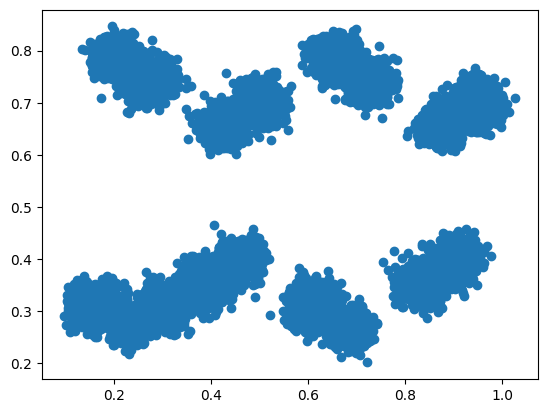

In [48]:
from matplotlib import pyplot as plt


plt.scatter(*ugh[:, :, 1, (0, 1)].T)

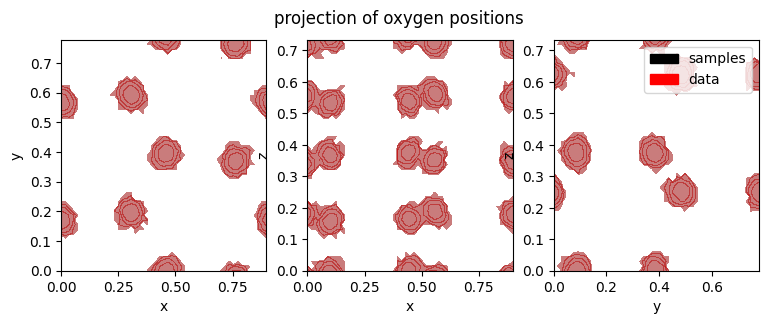

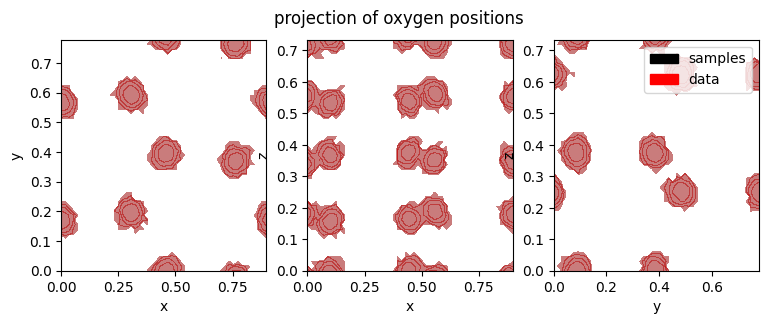

In [51]:
from rigid_flows.reporting import plot_oxygen_positions

plot_oxygen_positions(samples.obj.pos[:, :, 0], out.obj.pos[:, :, 0], target.box)

In [ ]:
asdf = samples.obj.pos

In [ ]:
from flox._src.flow import rigid

In [ ]:
rigid.from_euclidean(asdf[0, 0, (0, 1, 2)])[2:]

(Array(0.09572001, dtype=float32),
 Array(0.09571999, dtype=float32),
 Array(1.8242185, dtype=float32))

In [ ]:
asdf[0, 0]

Array([[0.35410124, 0.96830946, 0.05389997],
       [0.42291832, 0.91838706, 0.00991949],
       [0.3703351 , 1.0591396 , 0.02843112],
       [0.3631742 , 0.97267336, 0.04649135]], dtype=float32)

In [ ]:
# asdf[0, 0, 1] - asdf[0, 0, 0], asdf[0, 0, 2] - asdf[0, 0, 0]

In [ ]:
to_rigid(asdf[0, 0, :3])

Transformed(obj=RigidRepresentation(rot=Array([ 0.5047353 , -0.6526395 , -0.5511777 , -0.12452807], dtype=float32), pos=Array([0.35410124, 0.96830946, 0.05389997], dtype=float32), ics=InternalCoordinates(d_OH1=Array(0.09572, dtype=float32, weak_type=True), d_OH2=Array(0.09572, dtype=float32, weak_type=True), a_HOH=Array(1.8242182, dtype=float32, weak_type=True), d_OM=Array(0.0125, dtype=float32, weak_type=True), a_OM=Array(0.9121091, dtype=float32, weak_type=True))), ldj=Array(9.631294, dtype=float32))

In [ ]:
rigid.to_euclidean(*rigid.from_euclidean(asdf[0, 0, :3])), asdf[0, 0, :3]

(Array([[0.35410124, 0.96830946, 0.05389997],
        [0.42291832, 0.91838706, 0.00991948],
        [0.3703351 , 1.0591396 , 0.02843113]], dtype=float32),
 Array([[0.35410124, 0.96830946, 0.05389997],
        [0.42291832, 0.91838706, 0.00991949],
        [0.3703351 , 1.0591396 , 0.02843112]], dtype=float32))

In [154]:
# jax.vmap(jax.vmap(from_rigid))(jax.vmap(jax.vmap(to_rigid))(asdf).obj).obj - asdf

In [155]:
from flox.flow import bind

In [156]:
jax.vmap(density.potential)(samples.obj)

Array([-178.17667, -159.74104, -164.82028, -160.321  , -170.53   ,
       -155.51949, -153.70059, -154.61638, -166.6518 , -177.07855,
       -154.13593, -176.92596, -169.72615, -180.13869, -157.17789,
       -148.51108, -161.19168, -159.68921, -163.8478 , -152.0025 ,
       -169.84752, -156.54312, -153.56094, -177.21683, -152.22443,
       -169.73227, -173.90948, -165.52293, -181.91   , -168.22794,
       -166.36485, -165.89676, -166.35739, -168.58745, -166.80841,
       -176.06856, -169.61359, -161.74887, -168.21185, -150.48938,
       -151.53119, -174.0332 , -151.60786, -160.25116, -161.67032,
       -150.16536, -170.12074, -175.79338, -175.74628, -155.39337,
       -172.06726, -158.77919, -171.53061, -159.99062, -158.24788,
       -159.78487, -159.25272, -153.07507, -186.90529, -150.03526,
       -167.07657, -152.08293, -159.97852, -164.54813, -154.98183,
       -170.1467 , -163.96446, -163.8825 , -166.69296, -182.02861,
       -168.38538, -160.62502, -167.24951, -168.80295, -158.63

In [157]:
out.ldj

Array([-178.17667, -159.74101, -164.82025, -160.32097, -170.53   ,
       -155.51949, -153.70059, -154.61635, -166.6518 , -177.07852,
       -154.13593, -176.92596, -169.72615, -180.13866, -157.17786,
       -148.51108, -161.19168, -159.68921, -163.8478 , -152.00247,
       -169.84752, -156.54312, -153.56094, -177.21683, -152.2244 ,
       -169.73227, -173.90945, -165.52293, -181.91   , -168.2279 ,
       -166.36482, -165.89673, -166.35736, -168.58748, -166.80844,
       -176.06856, -169.61359, -161.74887, -168.21185, -150.48941,
       -151.53119, -174.03323, -151.60786, -160.25116, -161.67032,
       -150.16536, -170.12074, -175.79335, -175.74628, -155.39337,
       -172.06726, -158.77919, -171.53058, -159.99062, -158.24785,
       -159.78487, -159.25272, -153.07507, -186.90532, -150.03526,
       -167.07657, -152.0829 , -159.97849, -164.54813, -154.98186,
       -170.14667, -163.96446, -163.88248, -166.69296, -182.02861,
       -168.38538, -160.62502, -167.24948, -168.80295, -158.63

In [158]:
jax.nn.softmax(jax.vmap(density.potential)(out.obj) - out.ldj)

Array([0.00999956, 0.01000231, 0.01000017, 0.01000139, 0.01000292,
       0.00999926, 0.01000139, 0.00999742, 0.01000078, 0.010002  ,
       0.01000322, 0.00999956, 0.00999956, 0.01000109, 0.00999803,
       0.00999956, 0.00999987, 0.00999926, 0.01000109, 0.01000109,
       0.00999864, 0.00999803, 0.01000109, 0.01000292, 0.01000078,
       0.00999864, 0.00999987, 0.00999956, 0.00999895, 0.00999987,
       0.00999742, 0.01000109, 0.00999895, 0.01000048, 0.01000261,
       0.00999987, 0.00999773, 0.01000078, 0.00999803, 0.01000322,
       0.00999926, 0.01000139, 0.010002  , 0.00999529, 0.00999712,
       0.010002  , 0.00999834, 0.0099962 , 0.00999956, 0.00999956,
       0.01000231, 0.01000353, 0.00999895, 0.00999864, 0.01000017,
       0.01000078, 0.00999987, 0.00999712, 0.01000109, 0.01000078,
       0.01000078, 0.01000536, 0.00999773, 0.00999956, 0.00999742,
       0.01000261, 0.01000017, 0.01000383, 0.01000017, 0.00999987,
       0.00999987, 0.00999956, 0.0100017 , 0.00999712, 0.01000

In [163]:
energies = target.compute_energies(
        samples.obj, omm=True, aux=True, com=True, has_batch_dim=True
    )

aux_energies = energies["aux"]
omm_energies = energies["omm"]
com_energies = energies["com"]

target_energies = omm_energies + aux_energies + com_energies


energies = base.compute_energies(
        out.obj, omm=True, aux=True, com=True, has_batch_dim=True
    )

aux_energies = energies["aux"]
omm_energies = energies["omm"]
com_energies = energies["com"]

base_energies = omm_energies + aux_energies + com_energies

In [164]:
import jax.numpy as jnp
import numpy as np

weights = jax.nn.softmax(-target_energies + base_energies)
ess = np.square(np.sum(weights)) / np.sum(np.square(weights))
ess

99.99999

In [4]:
import jax


asdf = jax.vmap(density.sample)(jax.random.split(next(chain), 10000))


In [5]:
from rigid_flows.utils import smooth_maximum

# jax.vmap(
#     jax.vmap(smooth_maximum, in_axes=1, out_axes=0),
#     in_axes=2,
#     out_axes=1,
# )(oxy)

In [9]:
# import jax.numpy as jnp
# import numpy as np

# density.omm_model.compute_energies_and_forces(
#     np.array(data.pos[:1000]).reshape(1000, -1, 3),
#     np.array(jnp.diag(density.box.size))
# )[0]

/home/jonas/miniconda3/envs/rigid-flows/lib/python3.10/site-packages/jax/_src/random.py:400: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


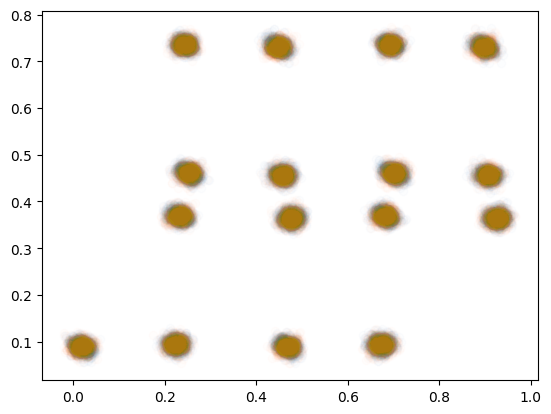

In [7]:
import jax
from matplotlib import pyplot as plt
import numpy as np


oxy = asdf.obj.pos.reshape(-1, 16, 4, 3)[:, :, 0, :] * density.data.stds[None] + density.data.modes[None]

oxy_ = data.pos.reshape(-1, 16, 4, 3)[:, :, 0, :]
oxy_ = jax.random.shuffle(next(chain), oxy_)
# oxy = jax.vmap(density.sample)(
#     jax.random.split(next(chain), 1000)
# ).obj.pos[:, :, 0]

# foo = jax.vmap(prior.sample)(
#     seed=jax.random.split(next(chain), 1000)
# # ).reshape(-1, 3)
# plt.scatter(*np.array(oxy[:500, :, (0, 1)]).T, alpha=0.01)

# plt.figure(figsize=(4, 4))
plt.scatter(*np.array(oxy[:1000, :, (0, 2)]).reshape(-1, 2).T, alpha=.01);
plt.scatter(*np.array(oxy_[:1000, :, (0, 2)]).reshape(-1, 2).T, alpha=0.01);
# plt.scatter(*density.data.modes[:, (0, 1)].T, c="r")
# plt.scatter(*np.array(foo[:, (1, 2)]).T)

In [54]:
from rigid_flows.system import SimulationBox
import jax.numpy as jnp

def unwrap(data: Data, box: SimulationBox):
    pos = data.pos 
    for i in range(pos.shape[1]):
        for j in range(pos.shape[2]):
            for k in range(pos.shape[3]):
                orig = pos[:, i, j, k]
                flipped = jnp.where(
                    orig < box.size[k] / 2,
                    orig + box.size[k],
                    orig
                )
                if jnp.std(orig) - jnp.std(flipped) > 0.01:
                    pos = pos.at[:, i, j, k].set(flipped)
    return pos

data = lenses.bind(data).pos.set(unwrap(data, density.box))

In [ ]:
from flox._src.flow.rigid import from_euclidean

In [ ]:
import jax.numpy as jnp

q, *_ = jax.vmap(jax.vmap(from_euclidean))(data.pos.reshape(-1, 16, 4, 3)[:1000, :, :3])

sign = jnp.sign(
    jnp.sum(q * q[(0,), :, :], axis=-1)
)
q = q * sign[:, :, None]

In [7]:
# q = q * jnp.sign(jax.random.normal(next(chain), (q.shape[0],)))[:, None, None]

In [8]:
# from flox import geom

# R = jax.vmap(jax.vmap(geom.quat_to_mat))(q)
# q = jax.vmap(jax.vmap(geom.mat_to_quat))(R)

In [9]:
rot_prior = RotationPrior(
    data
)

In [10]:
q_ = jax.vmap(rot_prior.sample)(jax.random.split(next(chain), 1000))

In [11]:
from rigid_flows.reporting import plot_quaternions

<Figure size 640x480 with 0 Axes>

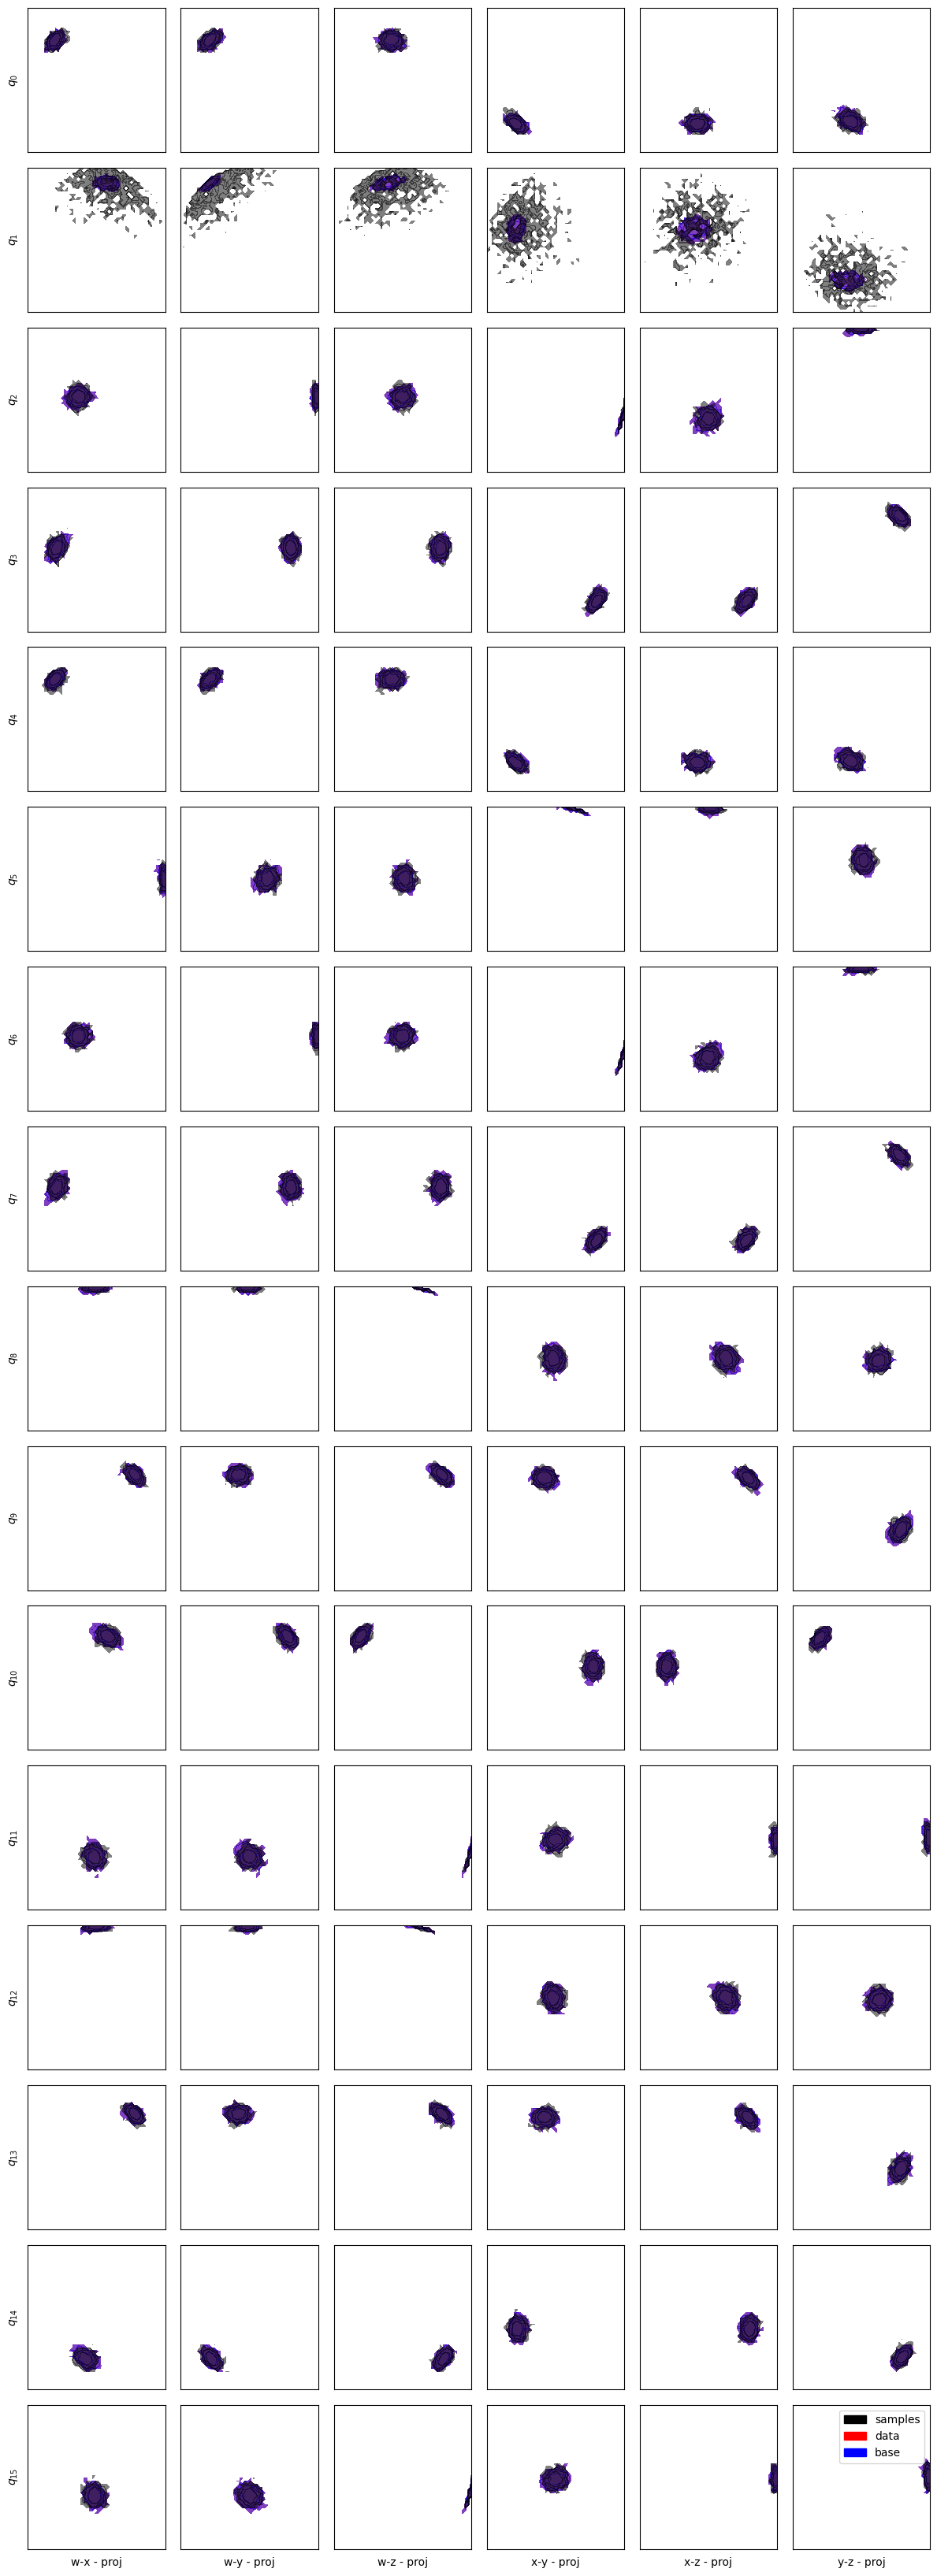

In [12]:
plot_quaternions(
    q[:1000], q_[:1000], q[:1000], np.arange(16)
); 

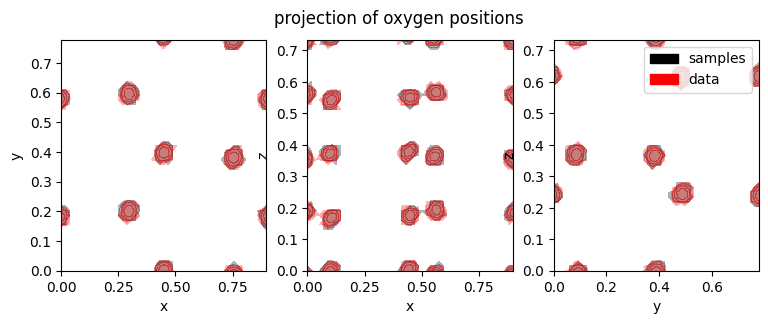

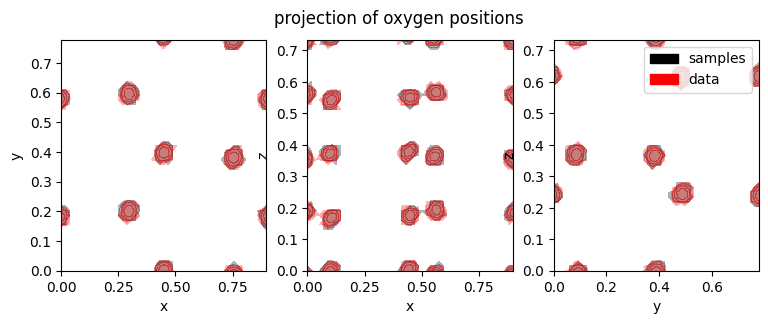

In [127]:
from rigid_flows.reporting import plot_oxygen_positions
plot_oxygen_positions(foo.reshape(-1, 16, 3), oxy.reshape(-1, 16, 3), density.box)

In [5]:
# flow

In [6]:
import jax.numpy as jnp

asdf = base.sample(next(chain)).obj
fdsa = flow.inverse(asdf).obj
qwer = flow.forward(fdsa).obj

# qwer.com, fdsa.com
qwer.aux - asdf.aux # , qwer.pos

DeviceArray([[ 2.0302832e-07,  2.9802322e-08, -2.9802322e-08],
             [ 1.7881393e-07, -1.1920929e-07, -2.3841858e-07],
             [-1.7881393e-07,  2.3841858e-07, -2.3841858e-07],
             [-5.9604645e-08, -3.3620745e-07,  1.1920929e-07],
             [ 1.9371510e-07,  0.0000000e+00,  2.9802322e-08],
             [ 2.6822090e-07,  1.4901161e-07, -1.1920929e-07],
             [ 5.9604645e-08, -4.4703484e-08,  5.9604645e-08],
             [ 2.3841858e-07, -2.3841858e-07,  1.7881393e-07],
             [-1.1920929e-07,  0.0000000e+00, -1.1920929e-07],
             [-1.1920929e-07,  4.7683716e-07, -1.6391277e-07],
             [-2.0861626e-07,  7.8231096e-08,  1.7881393e-07],
             [ 1.1920929e-07,  0.0000000e+00,  7.4505806e-08],
             [-3.5762787e-07,  2.3841858e-07, -1.1920929e-07],
             [ 0.0000000e+00,  0.0000000e+00,  2.9802322e-08],
             [ 2.9802322e-07,  0.0000000e+00,  5.9604645e-08],
             [ 2.9802322e-07, -2.3841858e-07,  1.788139

In [7]:
inp = density.sample(next(chain)).obj
out = flow.forward(inp)
rec = flow.inverse(out.obj).obj

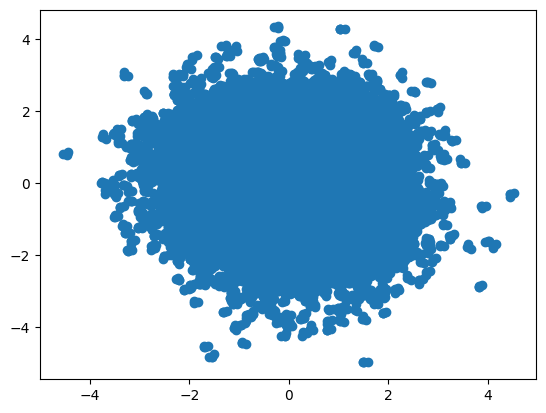

In [72]:
import numpy as np

v = np.load("./runs/2022-12-12_23:28:18/training_stage_0/epoch_1/samples.npz", allow_pickle=True)["obj"]

from matplotlib import pyplot as plt
x = np.frompyfunc(lambda d: d["pos"] + d["com"][:, None, None, :], 1, 1)(v)
# x = (x - x[:, 0, 0, :][:, None, None, :])
# plt.hist2d(x[..., 0].reshape(-1), x[..., 1].reshape(-1), bins=100);
plt.scatter(x[..., 0].reshape(-1), x[..., 1].reshape(-1))

In [3]:
# import jax / jnp

import jax
import jax.numpy as jnp

In [4]:
from flox.util import key_chain

# ensure consistent PRNG keys
chain = key_chain(42)

In [5]:
from jax import Array

# dataclasses that can be used as pytrees in vmap/tree_map etc.
from jax_dataclasses import pytree_dataclass


@pytree_dataclass(frozen=True)
class Box:
    """
    Simulation box.

    Args:
        max: maximum corner of the box
        min: minimum corner of the box
            defaults to (0, 0, 0)
    """

    max: jnp.ndarray
    min: jnp.ndarray = jnp.zeros(3)

    @property
    def size(self):
        return self.max - self.min

@pytree_dataclass
class State:
    """
    State being passed through the flow.
    
    Args:
        rot: quaternion describing current rotation
        pos: 3D vector describing current position
        ics: internal DoF of the system
        aux: auxiliary state
        box: simulation box
    """

    rot: Array
    pos: Array
    ics: tuple[Array, ...]
    aux: Array
    box: Box

### Neural Networks used for the flows

In [6]:
from functools import partial

# nn library
import equinox as eqx

# typing information
from jaxtyping import Float, Array  # type: ignore

from flox._src.nn.modules import dense
from flox.flow import Transformed

# purely functional handling of dataclasses
import lenses

KeyArray = jnp.ndarray | jax.random.PRNGKeyArray

class QuatEncoder(eqx.Module):
    """Encodes a quaternion into a flip-invariant representation."""
    encoder: eqx.nn.Linear

    def __init__(self, num_out: int, *, key: KeyArray):
        """Encodes a quaternion into a flip-invariant representation.

        Args:
            num_out (int): number of dimensions of output representation.
            key (KeyArray): PRNG Key for layer initialization
        """
        self.encoder = eqx.nn.Linear(4, num_out + 1, key=key)

    def __call__(self, quat: Float[Array, "... num_mols 4"]) -> Float[Array, "... num_mols 4"]:
        inp = jnp.stack([quat, -quat])
        out = jax.vmap(jax.vmap(self.encoder))(inp)
        weight = jax.nn.softmax(out[..., 0], axis=0)
        return (weight[..., None] * out[..., 1:]).sum(axis=0)


class Transformer(eqx.Module):
    """Standard impl of a transformer according to the `attention is all you need` paper."""

    attention_1: eqx.nn.MultiheadAttention
    attention_2: eqx.nn.MultiheadAttention

    norm_1: eqx.nn.LayerNorm
    norm_2: eqx.nn.LayerNorm
    norm_3: eqx.nn.LayerNorm

    dense: eqx.nn.Sequential

    def __init__(self, num_heads: int, num_dims: int, num_hidden: int, *, key: KeyArray):
        """Standard impl of a transformer according to the `attention is all you need` paper."

        Args:
            num_heads (int): number of transformer heads
            num_dims (int): node dimensionality
            num_hidden (int): hidden dimension of final dense layer
            key (KeyArray): PRNG Key for layer initialization
        """

        self.attention_1 = eqx.nn.MultiheadAttention(
            num_heads,
            num_dims * num_heads,
            use_key_bias=True,
            use_query_bias=False,
            use_output_bias=True,
            key=next(chain)
        )

        self.attention_2 = eqx.nn.MultiheadAttention(
            num_heads,
            num_dims * num_heads,
            use_key_bias=True,
            use_query_bias=False,
            use_output_bias=True,
            key=next(chain)
        )

        self.norm_1 = eqx.nn.LayerNorm(
            shape=(num_dims * num_heads),
            elementwise_affine=True)

        self.norm_2 = eqx.nn.LayerNorm(
            shape=(num_dims * num_heads),
            elementwise_affine=True)

        self.norm_3 = eqx.nn.LayerNorm(
            shape=(num_dims * num_heads),
            elementwise_affine=True)

        self.dense = dense(
            (num_dims * num_heads, num_hidden, num_dims * num_heads),
            jax.nn.silu,
            key=next(chain)
        )

    def __call__(self, input: Float[Array, "... seq_len node_dim"]) -> Float[Array, "... seq_len node_dim"]:

        input += self.attention_1(input, input, input)
        input = jax.vmap(self.norm_1)(input)

        input += self.attention_2(input, input, input)
        input = jax.vmap(self.norm_2)(input)

        input += jax.vmap(self.dense)(input)
        input = jax.vmap(self.norm_3)(input)

        return input        


class TransformerStack(eqx.Module):
    """Stack of transformer layers.

       DISCLAIMER: right now only implements a simple dense net!!!!
    """

    encoder: eqx.nn.Linear
    decoder: eqx.nn.Linear

    transformers: tuple[Transformer]

    # use simple dense net for now as transformers don't work (yet)
    foo: eqx.nn.Sequential

    def __init__(self, num_inp: int, num_out: int, num_heads: int, num_dims: int, num_hidden: int, num_blocks: int=0, *, key: KeyArray):
        chain = key_chain(key)
        self.encoder = eqx.nn.Linear(num_inp, num_heads * num_dims, key=next(chain))
        self.transformers = tuple(
            Transformer(num_heads, num_dims, num_hidden, key=next(chain))
            for _ in range(num_blocks)
        )
        self.decoder = eqx.nn.Linear(num_heads * num_dims, num_out, key=next(chain))


        self.foo = eqx.nn.Sequential([
            eqx.nn.Linear(num_inp * 16, num_hidden, key=next(chain)),
            eqx.nn.LayerNorm((num_hidden,), elementwise_affine=True),
            eqx.nn.Lambda(jax.nn.leaky_relu),
            # eqx.nn.Linear(num_hidden, num_hidden, key=next(chain)),
            # eqx.nn.LayerNorm((num_hidden,), elementwise_affine=True),
            # eqx.nn.Lambda(jax.nn.silu),
            eqx.nn.Linear(num_hidden, num_out * 16, key=next(chain)),
        ])

    def __call__(self, input: Float[Array, "... seq_len node_dim"]) -> Float[Array, "... seq_len node_dim"]:
        return self.foo(input.reshape(-1)).reshape(input.shape[0], -1)
        input = jax.vmap(self.encoder)(input)
        for transformer in self.transformers:
            input = transformer(input)
        
        return jax.vmap(self.decoder)(input)



### Flow layers

In [7]:
from functools import partial
from flox.flow import DoubleMoebius, Affine, Pipe, VectorizedTransform
from flox.util import unpack
from flox import geom

def affine_quat_fwd(q, A):
    A = jnp.eye(4) + A.reshape(4, 4)
    q_ = geom.unit(A @ q)
    ldj = jnp.linalg.slogdet(A)[1] - 4 * jnp.log(geom.norm(q_))
    return q_, ldj

def affine_quat_inv(q, A):
    A = jnp.eye(4) + A.reshape(4, 4)
    A = jnp.linalg.inv(A)
    q_ = geom.unit(A @ q)
    ldj = jnp.linalg.slogdet(A)[1] - 4 * jnp.log(geom.norm(q_))
    return q_, ldj


@pytree_dataclass
class QuaternionAffine:

    M: Array

    def forward(self, input: Array):
        new, ldj = affine_quat_fwd(input, self.M)
        return Transformed(new, ldj)

    def inverse(self, input: Array):
        new, ldj = affine_quat_inv(input, self.M)
        return Transformed(new, ldj)


def affine_forward(p, params):
    m, t = jnp.split(params, (9,), axis=0)
    m = m.reshape(3, 3) + jnp.eye(3)
    p = m @ p + t
    ldj = jnp.log(jnp.abs(geom.det3x3(m)))
    return p, ldj

def affine_inverse(p, params):
    m, t = jnp.split(params, (9,), axis=0)
    m = m.reshape(3, 3) + jnp.eye(3)
    p = jnp.linalg.inv(m) @ (p - t)
    ldj = -jnp.log(jnp.abs(geom.det3x3(m)))
    return p, ldj


@pytree_dataclass
class FullAffine:

    params: Array

    def forward(self, input: Array):
        p, ldj = affine_forward(input, self.params)
        return Transformed(p, ldj)

    def inverse(self, input: Array):
        p, ldj = affine_inverse(input, self.params)
        return Transformed(p, ldj)


class QuatUpdate(eqx.Module):
    """Flow layer updating the quaternion part of a state"""

    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Flow layer updating the quaternion part of a state.

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        self.net = TransformerStack(
            num_inp=num_aux + num_pos,
            num_out=4 * 4 + 4,# num_rot,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=key
        )

    def params(self, input: State):
        """Compute the parameters for the double moebius transform

        Args:
            input (State): current state

        Returns:
            Array: the parameter (reflection) of the double moebius transform
        """
        feats = jnp.concatenate([
            input.aux,
            input.pos
        ], axis=-1)
        out = self.net(feats)

        mat, reflection = jnp.split(out, (16,), -1)
        mat = mat * 1e-1

        reflection = reflection.reshape(input.rot.shape)
        reflection = jax.vmap(
            lambda x: x / (1 + geom.norm(x)) * 0.9999
        )(reflection)
        
        return mat, reflection

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        mat, reflection = self.params(input)
        new, ldj = unpack(Pipe([
            VectorizedTransform(QuaternionAffine(mat)),
            VectorizedTransform(DoubleMoebius(reflection))
        ]).forward(input.rot))
        return Transformed(
            lenses.bind(input).rot.set(new),
            ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        mat, reflection = self.params(input)
        new, ldj = unpack(Pipe([
            VectorizedTransform(QuaternionAffine(mat)),
            VectorizedTransform(DoubleMoebius(reflection))
        ]).inverse(input.rot))
        return Transformed(
            lenses.bind(input).rot.set(new),
            ldj
        )

class AuxUpdate(eqx.Module):
    """Flow layer updating the auxiliary part of a state"""

    symmetrizer: QuatEncoder
    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Flow layer updating the auxiliary part of a state.

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        chain = key_chain(key)
        self.symmetrizer = QuatEncoder(num_dims, key=next(chain))
        self.net = TransformerStack(
            num_inp=num_dims + num_pos,
            num_out=2 * num_aux,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=next(chain)
        )

    def params(self, input: State) -> tuple[Array, Array]:
        """Compute the parameters for the affine transform

        Args:
            input (State): current state

        Returns:
            tuple[Array, Array]: the parameters (shift, scale) of the affine transform
        """
        feats = jnp.concatenate([
            input.pos,
            self.symmetrizer(input.rot)
        ], axis=-1)
        out = self.net(feats)
        out = out.reshape(input.aux.shape[0], -1)
        shift, scale = jnp.split(out, 2, axis=-1)
        scale = scale * 1e-1
        return shift, scale

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        shift, scale = self.params(input)
        new, ldj = unpack(Affine(shift, scale).forward(input.aux))
        return Transformed(
            lenses.bind(input).aux.set(new),
            ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        shift, scale = self.params(input)
        new, ldj = unpack(Affine(shift, scale).inverse(input.aux))
        return Transformed(
            lenses.bind(input).aux.set(new),
            ldj
        )


class PosUpdate(eqx.Module):
    """Flow layer updating the position part of a state"""

    symmetrizer: QuatEncoder
    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Flow layer updating the position part of a state.

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        chain = key_chain(key)
        self.symmetrizer = QuatEncoder(num_dims, key=next(chain))
        self.net = TransformerStack(
            num_inp=num_dims + num_aux,
            num_out=12,#2 * num_pos,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=next(chain)
        )

    def params(self, input: State):# -> tuple[Array, Array]:
        """Compute the parameters for the affine transform

        Args:
            input (State): current state

        Returns:
            tuple[Array, Array]: the parameters (shift, scale) of the affine transform
        """
        feats = jnp.concatenate([
            input.aux,
            self.symmetrizer(input.rot)
        ], axis=-1)
        out = self.net(feats)
        out = out.reshape(input.pos.shape[0], -1)
        return out * 1e-2
        shift, scale = jnp.split(out, 2, axis=-1)
        scale = scale
        return shift, scale

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        # shift, scale = self.params(input)
        # new, ldj = unpack(Affine(shift, scale).forward(input.pos))
        params = self.params(input)
        new, ldj = unpack(VectorizedTransform(FullAffine(params)).forward(input.pos))
        return Transformed(
            lenses.bind(input).pos.set(new),
            ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        # shift, scale = self.params(input)
        # new, ldj = unpack(Affine(shift, scale).inverse(input.pos))
        params = self.params(input)
        new, ldj = unpack(VectorizedTransform(FullAffine(params)).inverse(input.pos))
        return Transformed(
            lenses.bind(input).pos.set(new),
            ldj
        )


class DisplacementEncoder(eqx.Module):
    """Encodes initial positions within the PBC box into
       displacement vectors relative to centers
       which are predicted from auxiliaries
    """

    symmetrizer: QuatEncoder
    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Encodes initial positions within the PBC box into
        displacement vectors relative to centers
        which are predicted from auxiliaries

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        chain = key_chain(key)
        self.symmetrizer = QuatEncoder(num_dims, key=next(chain))
        self.net = TransformerStack(
            num_inp=num_aux + num_dims,
            num_out=num_pos,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=next(chain)
        )

    def params(self, input: State) -> Array:
        """Compute the parameters (centers) given the input state

        Args:
            input (State): current state

        Returns:
            Array: the centers relative to which displacements are computed
        """
        feats = jnp.concatenate([
            input.aux,
            self.symmetrizer(input.rot)
        ], axis=-1)
        out = self.net(feats)
        center = out.reshape(input.pos.shape)
        center = jax.nn.sigmoid(center) * input.box.size
        return center

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        center = self.params(input)
        diff = geom.Torus(input.box.size).tangent(center, input.pos - center)
        ldj = jnp.zeros(())
        return Transformed(
            lenses.bind(input).pos.set(diff), ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        center = self.params(input)
        ldj = jnp.zeros(())
        pos = geom.Torus(input.box.size).shift(center, input.pos)    
        return Transformed(
            lenses.bind(input).pos.set(pos), ldj
        )

### priors

In [8]:
# a lot of useful standard densities implemented in JAX
import tensorflow_probability.substrates.jax as tfp  # type: ignore

# number
NUM_MOLECULES = 16
NUM_AUXILIARIES = 3

# params of the rotation prior (VMF)
base_rot_means = jnp.tile(jnp.array([1., 0., 0., 0.])[None], (NUM_MOLECULES, 1))
base_rot_concentration = jnp.ones((NUM_MOLECULES,)) * 40

# params of the auxilary prior (normal)
base_aux_means = jnp.zeros((NUM_MOLECULES, NUM_AUXILIARIES))
base_aux_stds = jnp.ones((NUM_MOLECULES, NUM_AUXILIARIES))

# params of the position / displacement prior (normal)
base_pos_means = jnp.zeros((NUM_MOLECULES, 3))
base_pos_stds = jnp.ones((NUM_MOLECULES, 3))

rot_sampler = tfp.distributions.VonMisesFisher(
        base_rot_means, base_rot_concentration
    )
pos_sampler = tfp.distributions.Normal(
    base_pos_means, base_pos_stds
)
aux_sampler = tfp.distributions.Normal(
    base_aux_means, base_aux_stds
)

def base_sampler(key: KeyArray, box: Box) -> Transformed[State]:
    """Samples from the base density

    Args:
        key (KeyArray): PRNG Key
        box (Box): simulation box

    Returns:
        Transformed[State]: a state sampled from the prior density
    """
    chain = key_chain(key)
    
    rot = rot_sampler.sample(seed=next(chain))
    rot = rot * jnp.sign(jax.random.normal(next(chain), shape=(rot.shape[0], 1)))
    pos = pos_sampler.sample(seed=next(chain))
    ics = (jnp.full(shape=(pos.shape[0],), fill_value=0.09572),
           jnp.full(shape=(pos.shape[0],), fill_value=0.09572),
           jnp.full(shape=(pos.shape[0],), fill_value=1.824218))
    aux = aux_sampler.sample(seed=next(chain))
    state = State(rot, pos, ics, aux, box)
    log_prob = base_density(state)
    return Transformed(state, log_prob)


def base_density(inp: State) -> Array:
    """Evaluate the base density for a state

    Args:
        state (State): the state to be evaluated

    Returns:
        Array: the energy of the state
    """
    # symmetrize latent distribution over rotations
    rot_prob = jax.nn.logsumexp(
        jnp.stack([
            rot_sampler.log_prob(inp.rot),
            rot_sampler.log_prob(-inp.rot)
        ]),
        axis=0
    ).sum()
    pos_prob = pos_sampler.log_prob(inp.pos).sum()
    aux_prob = aux_sampler.log_prob(inp.aux).sum()
    return -(rot_prob + aux_prob + pos_prob)



### load data

In [57]:
import numpy as np
from data.water.watermodel import WaterModel

temp = 250
ice_type = 'XI'
n_waters = 16

# path = ''
path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
info = f'ice{ice_type}_T{temp}_N{n_waters}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
raw = np.load(f'{path}MDtraj-{info}.npz')


import openmm
import openmm, openmm.app
from openmm import unit

from logging import getLogger

logger = getLogger("energy model")


def energy_model(model):
    integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1/unit.picosecond, 1*unit.femtosecond)
    if isinstance(model.system.getForces()[-1], (openmm.MonteCarloBarostat, openmm.MonteCarloAnisotropicBarostat, openmm.MonteCarloFlexibleBarostat)):
        model.system.getForces()[-1].setDefaultTemperature(temp)
    simulation = openmm.app.Simulation(model.topology, model.system, integrator)

    def _raw_eval(p: np.ndarray, b: np.ndarray):
        energy = np.zeros(())
        force = np.zeros_like(p)
        try:
            simulation.context.setPositions(p.reshape(-1, 3))
            if b.shape == (3,):
                b = np.diag(b)
            simulation.context.setPeriodicBoxVectors(*b)
            # simulation.context.computeVirtualSites()
            state = simulation.context.getState(getEnergy=True, getForces=True)
            energy = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
            force = state.getForces(asNumpy=True).value_in_unit(unit.kilojoule_per_mole / unit.nanometer)
        except Exception as e:
            logger.warning(str(e))

        return np.array(energy, np.float32), force.astype(np.float32).reshape(p.shape)
        

    def wrapped_callback(pos: Array, box: Array):
        shape_specs = (
            jax.ShapedArray((), jnp.float32),
            jax.ShapedArray(pos.shape, jnp.float32)
        )
        return jax.pure_callback(
            _raw_eval, shape_specs, pos, box
        )

    def eval_fwd(pos: Array, box: Array):
        energy, force = wrapped_callback(pos, box)
        return energy, (force, box)

    def eval_bwd(res, g):
        force, box = res
        return -g * force, jnp.zeros_like(box)

    @jax.custom_vjp
    def eval(pos: Array, box: Array):
        return eval_fwd(pos, box)[0]

    eval.defvjp(eval_fwd, eval_bwd)

    return eval, wrapped_callback, _raw_eval


energy, wrapped_energy_model, raw_energy_model = energy_model(model)




In [58]:
def precompute_forces(wrapped_model, raw):
    forces = []
    pos = raw["pos"]
    print(pos.shape)
    box = raw["box"][0]
    for i in list(range(len(pos))):
        _, force = raw_energy_model(pos[i], box)
        forces.append(force)
    forces = jnp.array(forces)
    return forces

_forces = precompute_forces(wrapped_energy_model, raw)

(100000, 64, 3)


In [59]:



from jaxtyping import Float, Array  # type: ignore
from dataclasses import astuple
import flox

from flox.flow import Lambda, Transform
from flox._src.flow import rigid

Scalar = Float[Array, ""] | float
Vector3 = Float[Array, "... 3"]
Quaternion = Float[Array, "... 4"]
Auxiliary = Float[Array, f"... AUX"]

AtomRepresentation = Float[Array, "... MOL 4 3"]


@pytree_dataclass(frozen=True)
class Data:
    """Raw data format."""
    positions: jnp.ndarray
    box: jnp.ndarray
    energy: jnp.ndarray
    force: jnp.ndarray | None = None



data = Data(*map(jnp.array, raw.values()))
data = Data(
    *astuple(data)[:-1], _forces
)

@pytree_dataclass(frozen=True)
class AugmentedData:
    """Data augmented with auxilaries and quaternion signs."""
    pos: Array
    aux: Array
    sign: Array
    box: Box
    force: jnp.ndarray | None = None


@pytree_dataclass(frozen=True)
class InternalCoordinates:
    d_OH1: Scalar = jnp.array(0.09572)
    d_OH2: Scalar = jnp.array(0.09572)
    a_HOH: Scalar = jnp.array(104.52 * jnp.pi / 180)
    d_OM: Scalar = jnp.array(0.0125)
    a_OM: Scalar = jnp.array(52.259937 * jnp.pi / 180)


@pytree_dataclass(frozen=True)
class RigidRepresentation:
    rot: Quaternion
    pos: Vector3
    ics: InternalCoordinates = InternalCoordinates()


def to_rigid(pos: AtomRepresentation) -> Transformed[RigidRepresentation]:
    q, p, *_ = rigid.from_euclidean(pos[:3])
    ldj = rigid.from_euclidean_log_jacobian(pos[:3])
    return Transformed(RigidRepresentation(q, p), ldj)


def from_rigid(rp: RigidRepresentation) -> Transformed[AtomRepresentation]:
    r_OM = rp.ics.d_OM * jnp.array(
        [jnp.sin(rp.ics.a_OM), 0.0, jnp.cos(rp.ics.a_OM)]
    )
    r_OM = flox.geom.qrot3d(rp.rot, r_OM)
    pos = rigid.to_euclidean(rp.rot, rp.pos, *astuple(rp.ics)[:3])
    ldj = rigid.to_euclidean_log_jacobian(rp.rot, rp.pos, *astuple(rp.ics)[:3])
    pos = jnp.concatenate([pos, (pos[0] + r_OM)[None]], axis=0)
    return Transformed(pos, ldj)


class RigidTransform(Transform[AtomRepresentation, RigidRepresentation]):
    def forward(
        self, inp: AtomRepresentation
    ) -> Transformed[RigidRepresentation]:
        return to_rigid(inp)

    def inverse(
        self, inp: RigidRepresentation
    ) -> Transformed[AtomRepresentation]:
        return from_rigid(inp)

In [60]:
def cutoff_potential(
    potential,
    reference,
    threshold
):

    def approximate_potential(inp):
        return 0.5 * jnp.square(
            inp - reference
        ).sum()

    def eval_fwd(
        inp
    ):
        original, grad = jax.value_and_grad(potential)(inp)
        gnorm = jnp.sqrt(1e-12 + jnp.sum(jnp.square(grad)))

        approx, grad_approx = jax.value_and_grad(approximate_potential)(inp)
        gnorm_approx = jnp.sqrt(1e-12 + jnp.sum(jnp.square(grad_approx)))
        grad_approx = grad_approx / gnorm_approx * threshold

        out = jnp.where(
            gnorm > threshold, 
            approx,
            original
        )
        grad = jnp.where(
            gnorm > threshold,
            grad_approx,
            grad
        )
        return out, grad

    def eval_bwd(
        g_inp,
        g_out
    ):
        return g_out * g_inp,

    @jax.custom_vjp
    def eval(
        inp
    ):
        return eval_fwd(inp)[0]

    eval.defvjp(
        eval_fwd, eval_bwd
    )

    return eval

In [61]:
# reference = np.array(data.positions[0]).reshape(16, 4, 3)

def target_density(inp: AugmentedData, cutoff=True) -> Array:
    """Evaluate the target density for a state

    Args:
        state (State): the state to be evaluated

    Returns:
        Array: the energy of the state
        
    """
    aux_prob = aux_sampler.log_prob(inp.aux).sum()

    if cutoff:
        pot = cutoff_potential(
            lambda x: energy(x, inp.box.size),
            reference,
            1e5 * 16
        )(inp.pos)
    else:
        pot = energy(inp.pos, inp.box.size)

    return -aux_prob + pot#energy(inp.pos, inp.box.size)


### initial transform mapping (augmented) data into a flow state

In [62]:
from flox._src.flow import rigid, Transform

@pytree_dataclass(frozen=True)
class InitialTransform:
    """Initial transform, transforming data into a state."""

    def forward(self, input: AugmentedData) -> Transformed[State]:
        rigid, ldj = unpack(VectorizedTransform(RigidTransform()).forward(input.pos))
        rigid = lenses.bind(rigid).rot.set(rigid.rot * input.sign)
        state = State(
            rigid.rot,
            rigid.pos,
            rigid.ics,
            input.aux,
            input.box
        )
        return Transformed(state, ldj)

    def inverse(self, input: State) -> Transformed[AugmentedData]:
        rigid = jax.vmap(RigidRepresentation)(
            input.rot,
            input.pos
        )
        pos, ldj = unpack(VectorizedTransform(RigidTransform()).inverse(rigid))
        sign = jnp.sign(input.rot[:, (0,)])
        data = AugmentedData(pos, input.aux, sign, input.box)
        return Transformed(data, ldj)

### define target density

In [23]:
def _force_box_vector(box: Array) -> Array:
    """Helper function that ensures box vectors are indeed vectors
       and no diagonal matrices.

    Args:
        box (Array): box vector of shape (3,) or (3, 3)

    Raises:
        ValueError: error if the box shape is neither (3,) or (3,3)

    Returns:
        Array: the box vector in shape (3,)
    """
    if box.shape == (3, 3):
        return jnp.diag(box)
    elif box.shape == (3,):
        return box
    else:
        raise ValueError(f"Cannot handle box of shape {box.shape}")


def target_sampler(key: KeyArray) -> Transformed[AugmentedData]:
    """Samples from the target (data) distribution.

    Auxiliaries are drawn from a standard normal distribution.

    Quaternion signs are drawn from {-1, 1} uniformily random.

    Args:
        key (KeyArray): PRNG Key

    Returns:
        Transformed[AugmentedData]: Sample from the target distribution.
    """
    chain = key_chain(key)
    idx = jax.random.randint(next(chain), minval=0, maxval=len(data.positions), shape=())
    box = Box(_force_box_vector(data.box[idx]))
    pos = data.positions[idx].reshape(-1, 4, 3)
    if data.force is not None:
        force = data.force[idx]
    else:
        force = None
    aux = aux_sampler.sample(seed=next(chain))
    sign = jnp.sign(jax.random.normal(next(chain), shape=(NUM_MOLECULES, 1)))
    return Transformed(AugmentedData(pos, aux, sign, box, force), jnp.zeros(()))


### define flow

In [24]:
from typing import Any


def _preprocess(key: KeyArray, num_aux: int) -> Pipe[AugmentedData, State]:
    """The initial blocks handing:

     - mapping augmented data into a state
     - predicting position centers from the auxilaries
     - mapping positions into displacements relative to position centers

    Args:
        key (KeyArray): PRNG key
        num_aux (int): number of auxilaries

    Returns:
        Pipe[AugmentedData, State]: the initial transform
    """
    chain = key_chain(key)
    return Pipe[AugmentedData, State]([
        InitialTransform(),
        AuxUpdate(num_aux, num_hidden=1024, key=next(chain)),
        DisplacementEncoder(num_aux, num_hidden=1024, key=next(chain)),
    ])


def _coupling(key: KeyArray, num_aux: int) -> Pipe[State, State]:
    """Creates a coupling block consisting of:

     - an update to the auxilaries
     - an update to the quaterions
     - an update to the positions

    Args:
        key (KeyArray): PRNG Key
        num_aux (int): number of auxilaries

    Returns:
        Pipe[State, State]: the coupling block
    """
    chain = key_chain(key)
    return Pipe[State, State]([
        AuxUpdate(num_aux, num_hidden=1024, key=next(chain)),
        QuatUpdate(num_aux, num_hidden=1024, key=next(chain)),
        PosUpdate(num_aux, num_hidden=1024, key=next(chain)),
    ])


def _make_flow(key: KeyArray, num_aux: int, num_blocks: int=4) -> Pipe[AugmentedData, State]:
    """Creates the final flow composed of:

     - a preprocessing transformation
     - multiple coupling blokcks

    Args:
        key (KeyArray): PRNG key
        num_aux (int): number of auxilaries
        num_blocks (int, optional): number of coupling blocks. Defaults to 2.

    Returns:
        Pipe[AugmentedData, State]: the final flow
    """
    chain = key_chain(key)
    blocks: list[Transform[Any, Any]] = [_preprocess(next(chain), num_aux)]
    for _ in range(num_blocks):
        blocks.append(_coupling(next(chain), num_aux))
    blocks.append(AuxUpdate(num_aux, num_hidden=1024, key=next(chain)))
    return Pipe[AugmentedData, State](blocks)


flow = _make_flow(next(chain), NUM_AUXILIARIES)

### Ensure that the flow is indeed invertible

In [25]:
inp = target_sampler(next(chain)).obj
out = flow.forward(inp).obj
back = flow.inverse(out).obj
assert jnp.max(jnp.abs(back.pos % Box(_force_box_vector(data.box[0])).size - inp.pos % Box(_force_box_vector(data.box[0])).size)) < 1e-5

### Setup optimization and sampling

In [26]:
chain = key_chain(42)

import optax
from optax import GradientTransformation

steps = 3_000
n_stages = 4
lrs = [10 ** (-3 - i) for i in range(n_stages)]
total_steps = n_stages * steps

scheduler = optax.join_schedules(
    tuple(
        optax.cosine_decay_schedule(lr, steps, alpha=0.1)
        for lr in lrs
    ),
    (steps,) * (n_stages  - 1)
)

optim = optax.adam(scheduler)

flow = _make_flow(next(chain), NUM_AUXILIARIES)




In [27]:
# # sample data

# orig = jax.vmap(target_sampler)(jax.random.split(next(chain), NUM_SAMPLES))
# orig = lenses.bind(orig).obj.pos.set(orig.obj.pos)
# q_orig = jax.vmap(InitialTransform().forward)(orig.obj).obj.rot

In [28]:
from flox.flow import PullbackSampler, PushforwardSampler, bind, pure, Inverted

def sample_loss(
    key,
    flow,
    base_sampler,
    base_energy,
    target_sampler,
    target_energy,
    weights,
):
    chain = key_chain(key)

    def neg_log_likelihood(sample):
        latent = flow.forward(sample)
        nll = base_energy(latent.obj) - latent.ldj
        return nll


    def force_matching_loss(sample):
        nll_loss, model_force = jax.value_and_grad(neg_log_likelihood)(sample)
        # _, target_force = wrapped_energy_model(sample.pos, sample.box.size)
        target_force = sample.force

        # fm_loss = jnp.square(
        #     model_force.pos + target_force
        # ).sum()
        fm_loss = optax.huber_loss(
            model_force.pos.reshape(-1) + target_force.reshape(-1)
        ).sum()
        return fm_loss

    nll = weights[0] * neg_log_likelihood(target_sampler(next(chain)).obj)

    fm = weights[1] * force_matching_loss(target_sampler(next(chain)).obj)
    
    return nll + fm

def batch_loss(
    key,
    flow,
    base_sampler,
    base_energy,
    target_sampler,
    target_energy,
    weights,
    num_samples: int = 128
):
    keys = jax.random.split(key, num_samples)

    loss = jax.vmap(
        lambda key: sample_loss(
            key=key, 
            flow=flow, 
            base_sampler=base_sampler, 
            base_energy=base_energy, 
            target_sampler=target_sampler, 
            target_energy=target_energy,
            weights=weights,
        )
    )(keys)
    
    return jnp.mean(loss)


def make_update_step(
    optim,
    base_sampler,
    base_energy,
    target_sampler,
    target_energy,
    num_samples: int = 128,
):

    @eqx.filter_jit
    def step(key, flow, opt_state, weights):
        # param, static = eqx.partition(flow, eqx.is_array)  # type: ignore
        loss, grad = eqx.filter_value_and_grad(
            lambda flow: batch_loss(
                key=key,
                flow=flow,
                base_sampler=base_sampler,
                base_energy=base_energy,
                target_sampler=target_sampler,
                target_energy=energy,
                num_samples=num_samples,
                weights=weights,
            )
        )(flow)
        updates, opt_state = optim.update(grad, opt_state)
        flow = eqx.apply_updates(flow, updates)
        return loss, flow, opt_state
    
    return step

In [29]:
from flox._src.nn.train import free_energy_step, mle_step


params, static = eqx.partition(flow, eqx.is_array)  # type: ignore
# opt_state0 = optim0.init(params)

# step = free_energy_step(
#     base_density,
#     optim,
#     target_sampler,
#     num_samples=128
# )

opt_state = optim.init(params)

step = make_update_step(
    optim,
    partial(base_sampler, box=Box(_force_box_vector(data.box[0]))),
    base_density,
    target_sampler,
    target_density,
    num_samples=128,
)

In [35]:
NUM_ITERS = 10_000
PRINT_ITERS = 100
loss = np.full(NUM_ITERS//PRINT_ITERS, np.nan)

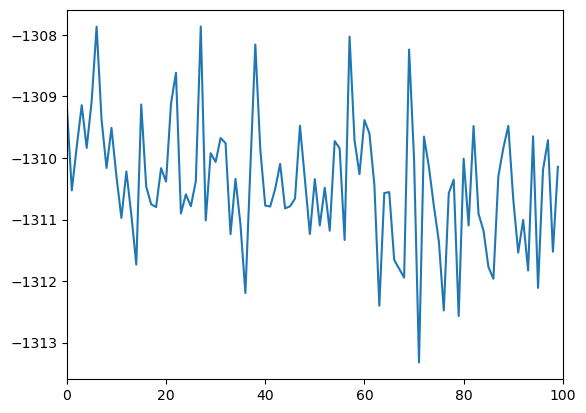

iter: 9999/10000, loss (ml): -1310.14
CPU times: user 5min 50s, sys: 11.6 s, total: 6min 1s
Wall time: 5min 37s


In [36]:
%%time
from matplotlib import pyplot as plt
from IPython.display import clear_output

for i in range(NUM_ITERS):
    loss[i//PRINT_ITERS], flow, opt_state = step(next(chain), flow, opt_state, weights=jnp.array([1., 0.]))  # type: ignore
    if (i + 1) % PRINT_ITERS == 0:
        clear_output(wait=True)
        plt.plot(loss)
        plt.xlim(0, len(loss))
        plt.show()
        print(f"iter: {i+1}/{NUM_ITERS}, loss (ml): {loss[i//PRINT_ITERS]:.6}")

### sample from data / model / prior

In [37]:
NUM_SAMPLES = 10_000

In [38]:
# sample data

orig = jax.vmap(target_sampler)(jax.random.split(next(chain), NUM_SAMPLES))
orig = lenses.bind(orig).obj.pos.set(orig.obj.pos)
q_orig = jax.vmap(InitialTransform().forward)(orig.obj).obj.rot

In [39]:
from ast import parse
from collections.abc import Iterable, Mapping
from dataclasses import dataclass, is_dataclass
from types import GenericAlias


@dataclass(frozen=True)
class A:
    a: list[list[int] | list[str]]

a = A([123])

issubclass(a.__dataclass_fields__["a"].type.__origin__, Iterable)
# issubclass(a.__dataclass_fields__["a"].type, Iterable)

def parse(typ, value):
    if is_dataclass(typ):
        return parse_data_class(typ, value)
    elif isinstance(typ, GenericAlias):
        return parse_generic_alias(typ, value)
    elif issubclass(typ, Mapping):
        return parse_mapping(Any, Any, value)
    elif issubclass(typ, Iterable):
        return parse_iterable(Any, value)
    else:
        return value

from itertools import repeat

def parse_iterable(value_types, values):
    assert isinstance(values, Iterable)
    if not isinstance(value_types, Iterable):
        return tuple(
            parse(value_types, val) for val in values
        )
    else:
        return tuple(
            parse(typ, val) for typ, val in zip(
                value_types,
                values,
                strict=True
            )
        )

def parse_data_class(clz, kwargs):
    assert is_dataclass(clz)
    assert isinstance(kwargs, dict)
    parsed_kwargs = {}
    for name, field in clz.__dataclass_fields__.items():
        if name in kwargs:
            value = parse(field.type, kwargs[name])
            parsed_kwargs[name] = value
    return clz(**parsed_kwargs)


def parse_mapping(key_type, value_type, value):
    assert isinstance(value, Mapping)
    return {
        k: parse(value_type, v)
        for k, v in value.items()
    }


def parse_generic_alias(
    alias, value
):
    origin = alias.__origin__
    args = alias.__args_
    if issubclass(origin, tuple):
        if len(args) == 1 or args[1] == ...:
            return parse_iterable(args[0], value)
        else:
            return parse_iterable(args, value)
    elif issubclass(origin, Iterable):
        return parse_iterable(args[0], value)
    elif issubclass(origin, Mapping):
        key_type, value_type = args
        parse_mapping(key_type, value_type, value)
    else:
        raise ValueError(f"Cannot parse generic alias {origin}")

In [41]:
# sample model

# sampling function (jit compiled)
sample_from_model = jax.jit(jax.vmap(
    PullbackSampler(partial(base_sampler, box=Box(_force_box_vector(data.box[0]))), flow)
))

samples = sample_from_model(jax.random.split(next(chain), NUM_SAMPLES))
q_samples = jax.vmap(InitialTransform().forward)(samples.obj).obj.rot

In [43]:
# sample prior

prior = jax.vmap(partial(base_sampler, box=Box(_force_box_vector(data.box[0]))))(jax.random.split(next(chain), NUM_SAMPLES))
q_prior = prior.obj.rot

### compare positions and rotations

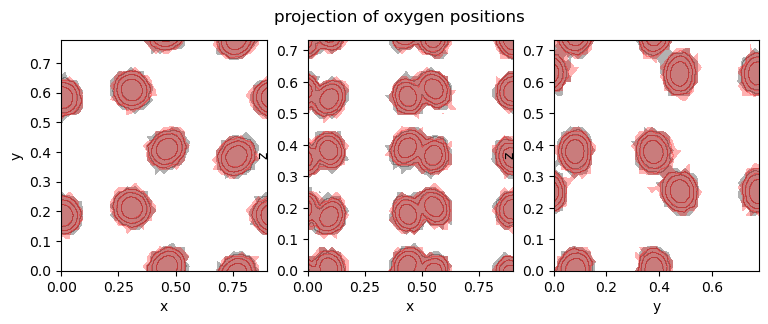

In [44]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import itertools as it

box = Box(_force_box_vector(data.box[0]))

def _compute_contour_levels(qi, qj, threshold: float = 1e-5, num_levels: int = 5, num_bins: int = 50) -> tuple[Array, ...]:
    h, *bins = jnp.histogram2d(
            qi,
            qj,
            density=True,
            bins=num_bins + 1
        )
    h = jnp.log(threshold + h)
    levels = jnp.linspace(
        h[h > jnp.log(1e-4)].min(),
        h.max(),
        num_levels
    )
    return h, levels, *bins

def _plot_contour_lines(p, box, dim_i, dim_j, colors: str):
    num_bins = 50
    gx, gy = jnp.meshgrid(
        jnp.linspace(box.min[dim_i], box.max[dim_i], num_bins + 1),
        jnp.linspace(box.min[dim_j], box.max[dim_j], num_bins + 1),
    )
    h, levels, *bins = _compute_contour_levels(
        p[:, :, 0, dim_i].reshape(-1) % box.size[dim_i],
        p[:, :, 0, dim_j].reshape(-1) % box.size[dim_j],
    )
    plt.contourf(gx, gy, h, levels, colors=colors, alpha=0.3, extend="neither", antialiased = False)


plt.figure(figsize=(3 * 3, 1 * 3))
plt.suptitle("projection of oxygen positions")
labels = ("x", "y", "z")
for k, (i, j) in enumerate(it.combinations(range(3), 2), start=1):
    
    plt.subplot(1, 3, k)
    _plot_contour_lines(
        samples.obj.pos,
        Box(_force_box_vector(data.box[0])),
        i, j,
        "black"
    )
    _plot_contour_lines(
        orig.obj.pos,
        Box(_force_box_vector(data.box[0])),
        i, j,
        "red"
    )
    plt.ylabel(labels[j])
    plt.xlabel(labels[i])   


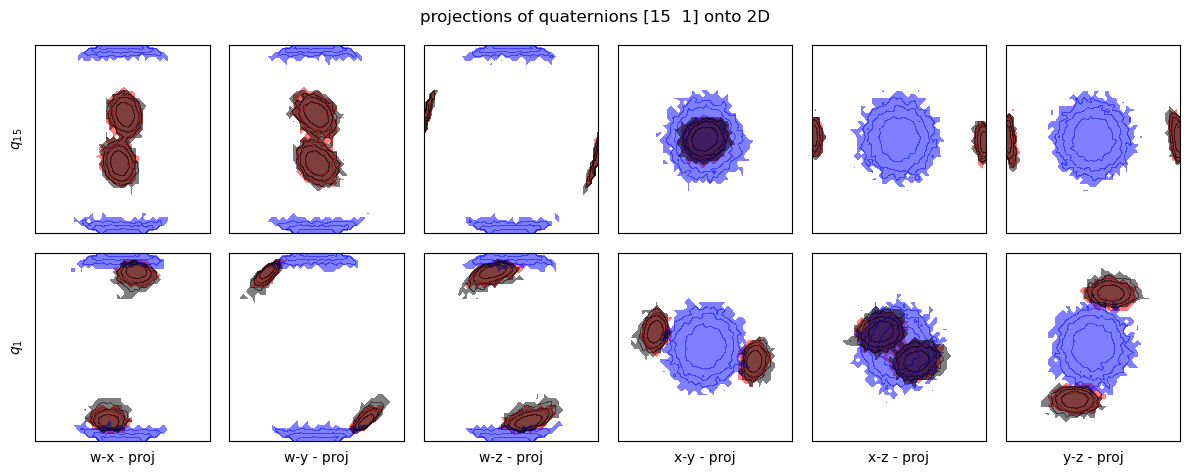

In [45]:
import itertools as it

from matplotlib import pyplot as plt

from matplotlib.colors import LogNorm

NUM_PLOTTED = 2
plt.figure(figsize=(6 * 2, NUM_PLOTTED * 2 + .8))

idx = np.random.randint(16, size=(NUM_PLOTTED,))

plt.suptitle(f"projections of quaternions {idx} onto 2D")

num_bins = 50
gx, gy = jnp.meshgrid(
    jnp.linspace(-1, 1, num_bins),
    jnp.linspace(-1, 1, num_bins)
)

def _compute_contour_levels(qi, qj, threshold: float = 1e-5, num_levels: int = 5, num_bins: int = 50) -> tuple[Array, Array]:
    h, *_ = jnp.histogram2d(
            qi,
            qj,
            density=True,
            bins=(jnp.linspace(-1, 1, num_bins + 1), jnp.linspace(-1, 1, num_bins + 1))  # type: ignore
        )
    h = jnp.log(threshold + h)
    levels = jnp.linspace(
        h[h > jnp.log(1e-4)].min(),
        h.max(),
        num_levels
    )
    return h, levels

def _plot_contour_lines(gx, gy, q, quat_idx, dim_i, dim_j, colors: str):
    h, levels = _compute_contour_levels(
        q[:, quat_idx, dim_i],
        q[:, quat_idx, dim_j]
    )
    plt.contourf(gx, gy, h, levels, colors=colors, alpha=0.5, extend="neither", antialiased = False)

labels = ["w", "x", "y", "z"]

n = 0
for i, (j, k) in it.product(idx, it.combinations(range(4), 2)):
    n = n + 1
    plt.subplot(NUM_PLOTTED, 6, n)

    _plot_contour_lines(
        gx, gy, q_orig, i, j, k, "red"
    )

    _plot_contour_lines(
        gx, gy, q_prior, i, j, k, "blue"
    )

    _plot_contour_lines(
        gx, gy, q_samples, i, j, k, "black"
    )

    if n % 6 == 1:
        plt.ylabel(f"$q_{{{i}}}$")

    if (6 * NUM_PLOTTED - n) < 6:
        plt.xlabel(f"{labels[j]}-{labels[k]} - proj")
    
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.tight_layout()

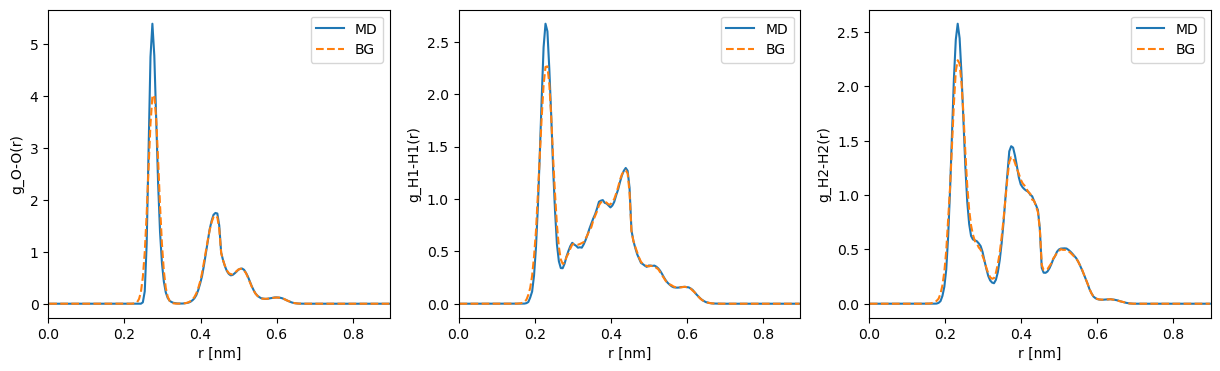

In [72]:
import mdtraj as md

r_range = [0, model.box.max()]
MDtraj = md.Trajectory(data.positions[:NUM_SAMPLES], model.mdtraj_topology)
MDtraj.unitcell_vectors = np.resize(model.box, (NUM_SAMPLES,3,3))
BGtraj = md.Trajectory(samples.obj.pos.reshape(NUM_SAMPLES, model.system.getNumParticles(), 3), model.mdtraj_topology)
BGtraj.unitcell_vectors = MDtraj.unitcell_vectors


names = ['O', 'H1', 'H2']
n = 1
plt.figure(figsize=(5*len(names), 4))
for a in names:
    plt.subplot(1, len(names), n)
    
    ij = model.mdtraj_topology.select_pairs(f'name == {a}', f'name == {a}')
    rdf = md.compute_rdf(MDtraj, ij, r_range=r_range)
    plt.plot(*rdf, label='MD')
    rdf = md.compute_rdf(BGtraj, ij, r_range=r_range)
    plt.plot(*rdf, ls='--', label='BG')
    
    plt.ylabel(f'g_{a}-{a}(r)')
    plt.xlabel('r [nm]')
    plt.xlim(r_range)
    plt.legend()
    n += 1
    
plt.show()

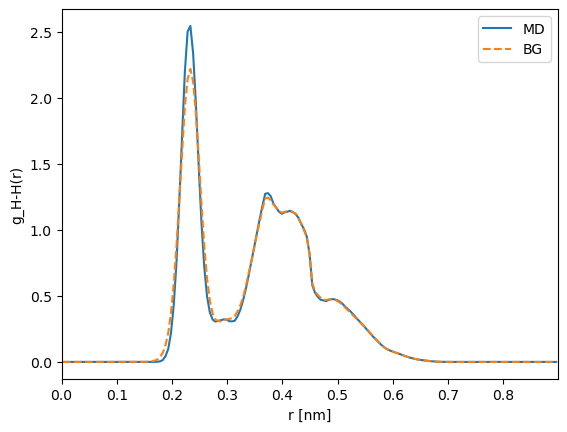

In [73]:
# ij = model.mdtraj_topology.select_pairs('True', 'True')
a = 'H'
ij = model.mdtraj_topology.select_pairs(f'symbol == {a}', f'symbol == {a}')
ij = ij[(ij[:,1]-ij[:,0]) > 1] #avoid same-molecule atoms
rdf = md.compute_rdf(MDtraj, ij, r_range=r_range)
plt.plot(*rdf, label='MD')
rdf = md.compute_rdf(BGtraj, ij, r_range=r_range)
plt.plot(*rdf, ls='--', label='BG')

plt.ylabel(f'g_{a}-{a}(r)')
plt.xlabel('r [nm]')
plt.xlim(r_range)
plt.legend()
plt.show()

### save to file

In [46]:
SAVE_DATA = False

In [47]:
if SAVE_DATA:
    import datetime
    stamp = datetime.datetime.now().strftime("%d_%m_%Y-%H_%M_%S")
    path = "/group/ag_cmb/jonkhler/experiments/rigids"
    file = f"samples_{stamp}.npz"
    np.savez(f"{path}/{file}", positions=np.array(samples.obj))

### compare energies

In [63]:
eval_target_density_ = jax.jit(jax.vmap(partial(target_density)))

In [64]:
from tqdm import tqdm


num_samples = 1_000_000
num_per_batch = 10_000


def gather_model_energies(
    key,
    base,
    flow,
    num_samples: int = 1_000_000,
    num_per_batch: int = 10_000,
):

    chain = key_chain(key)

    @jax.jit
    @jax.vmap
    def gather(key):
        latent, u_base = unpack(base(key))
        samples, ldj = unpack(flow.inverse(latent))
        u_tot = target_density(samples, cutoff=False)
        u_aux = -aux_sampler.log_prob(samples.aux).sum()
        return u_tot, u_aux, u_base, ldj
    
    us_target = []
    us_aux = []
    us_base = []
    ldjs = []

    num_sampled = 0
    while num_sampled < num_samples:
        u_target, u_aux, u_base, ldj = gather(jax.random.split(next(chain), num_per_batch))
        us_target.append(np.array(u_target))
        us_aux.append(np.array(u_aux))
        us_base.append(np.array(u_base))
        ldjs.append(np.array(ldj))
        num_sampled += len(u_target)
    
    us_target = np.concatenate(us_target)
    us_aux = np.concatenate(us_aux)
    us_base = np.concatenate(us_base)
    ldjs = np.concatenate(ldjs)

    return us_target, us_aux, us_base, ldjs

In [65]:
us_target, us_aux, us_base, ldjs = gather_model_energies(
    next(chain),
    partial(base_sampler, box=Box(_force_box_vector(data.box[0]))),
    flow,
    num_samples=100_000,
    num_per_batch=10_000
)

In [66]:
auxs = jax.vmap(aux_sampler.sample)(seed=jax.random.split(next(chain), 10_000))
auxs = -jax.vmap(aux_sampler.log_prob)(auxs).sum((-1, -2))

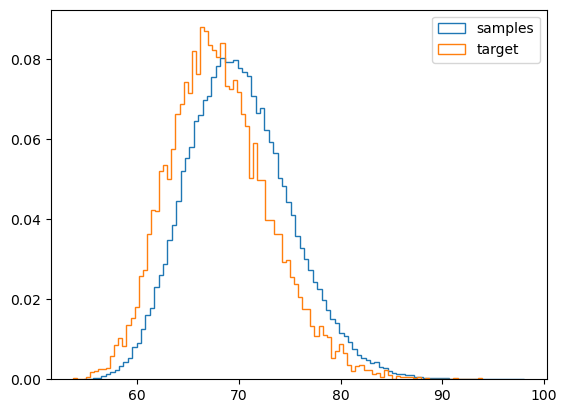

In [67]:
plt.hist(us_aux, density=True, bins=100, histtype="step", label="samples");
plt.hist(auxs, density=True, bins=100, histtype="step", label="target");
plt.legend()

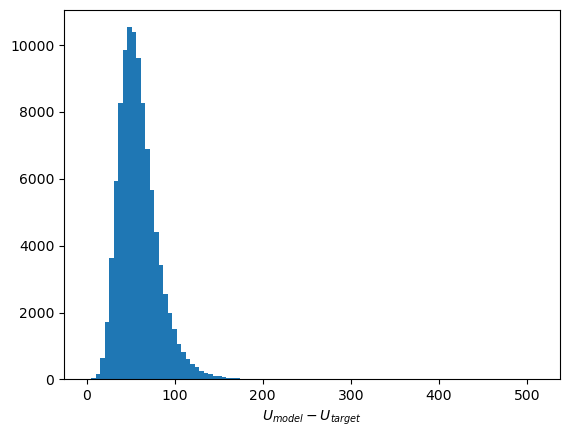

In [68]:
diffs = (us_target - us_base - ldjs) - jnp.min(us_target - us_base - ldjs)
diffs = diffs[diffs < 1e3]
plt.hist(
    diffs,
    bins=100,
);
plt.xlabel("$U_{model} - U_{target}$");

In [69]:
log_weights = jax.nn.log_softmax(-us_target + us_base + ldjs)
ess = 1. / jnp.sum(jnp.square(jnp.exp(log_weights))) / len(log_weights)
print(f"ess: {ess * len(log_weights):g}, i.e. {ess:.3%}")

ess: 3.3153, i.e. 0.003%


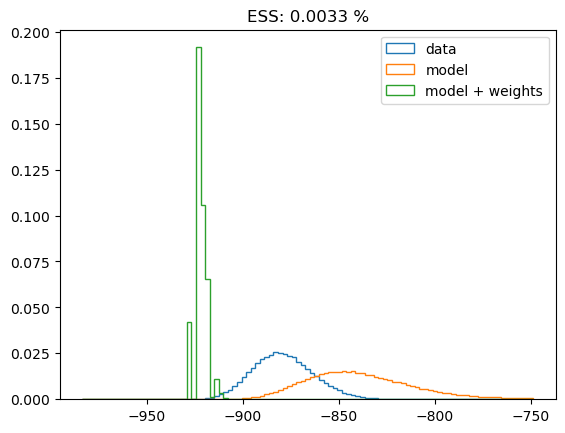

In [70]:
u_data = np.array(raw["ene"].reshape(-1))

bins = jnp.linspace(
    u_data.min() - 50, u_data.max() + 50, 100
)

plt.title(f"ESS: {ess * 100:.2} %")
plt.hist(u_data, bins=bins, histtype="step", density=True, label="data");
plt.hist(np.array(us_target - us_aux), bins=bins, histtype="step", density=True, label="model");
plt.hist(np.array(us_target - us_aux), bins=bins, histtype="step", weights=np.array(jnp.exp(log_weights)), density=True, label="model + weights");
plt.legend()
